# 월드클래스로 승급하기 위한 전략 수립 분석

<목차>

1. 개요

2. EDA

3. Feature Engineering

4. 모델 개발

5. 모델 평가

---
---

## 개요

### 1. 목적
승리에 주요하게 영향을 미치는 특성을 파악하고 내 경기의 특성과 비교 분석하여 <월드클래스>로 승급하기 위한 승리 전략을 수립한다.

### 2. 데이터 설명
- FC온라인 API를 통해 수집한 다른 유저들의 경기 데이터
- 득점한 선수에 관련한 데이터는 분석에 활용하지 않고, 유저의 플레이 데이터만 활용한다.
- 매치ID 중복 데이터 존재 > 경기 기준이 아닌 골 기준으로 ROW가 집계됨(득점 좌표 데이터 활용하기 위함)
- API를 통해 호출한 데이터를 가공하여 다운 받은 CSV 파일을 호출한다.

### 3. 분석 환경 조성

#### ㄴ 라이브러리 호출

In [1]:
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, log_loss
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from imblearn.combine import SMOTETomek
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors
# from catboost import CatBoostClassifier

from math import sqrt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ▶ Warnings 제거
import warnings
warnings.filterwarnings('ignore')

# ▶ 한글 폰트 설정하기
plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] =False

#### ㄴ 데이터 호출

In [2]:
# 데이터 프레임 생성
match_df_1 = pd.read_csv('/Users/Moon/Airflow/data/25032721_cleaned_match_data.csv', encoding='utf-8-sig')
match_df_2 = pd.read_csv('/Users/Moon/Airflow/data/25032900_cleaned_match_data.csv', encoding='utf-8-sig')
match_df_3 = pd.read_csv('/Users/Moon/Airflow/data/25040100_cleaned_match_data.csv', encoding='utf-8-sig')
match_df_4 = pd.read_csv('/Users/Moon/Airflow/data/25040104_cleaned_match_data.csv', encoding='utf-8-sig')
match_df_5 = pd.read_csv('/Users/Moon/Airflow/data/25040200_cleaned_match_data.csv', encoding='utf-8-sig')
match_df_6 = pd.read_csv('/Users/Moon/Airflow/data/25040204_cleaned_match_data.csv', encoding='utf-8-sig')
match_df_7 = pd.read_csv('/Users/Moon/Airflow/data/25040300_cleaned_match_data.csv', encoding='utf-8-sig')

print(match_df_1.shape)
print(match_df_2.shape)
print(match_df_3.shape)
print(match_df_4.shape)
print(match_df_5.shape)
print(match_df_6.shape)
print(match_df_7.shape)

(359, 43)
(340, 43)
(513, 43)
(19, 43)
(595, 43)
(105, 43)
(435, 43)


In [3]:
# 데이터 프레임 확인
match_df_1.head()

,matchId,matchDate,matchType,ouid,nickname,matchResult,matchEndType,foul,injury,redCards,...,goalTime,x,y,type,result,spId,assist,assistSpId,hitPost,inPenalty
0,67e5abd6293b2e29d79b74f4,2025-03-27T19:59:51,50,78bd4904e360e8f15281c765ad9069e1,김진효,무,0,0,0,0,...,1545,0.936611,0.543738,2,3,827167198,True,825054050,False,True
1,67e5abd6293b2e29d79b74f4,2025-03-27T19:59:51,50,78bd4904e360e8f15281c765ad9069e1,김진효,무,0,0,0,0,...,16777585,0.846402,0.387678,1,1,827167198,True,814200145,False,True
2,67e5abd6293b2e29d79b74f4,2025-03-27T19:59:51,50,78bd4904e360e8f15281c765ad9069e1,김진효,무,0,0,0,0,...,16777916,0.818322,0.401577,2,2,827167198,True,814200145,False,False
3,67e5abd6293b2e29d79b74f4,2025-03-27T19:59:51,50,78bd4904e360e8f15281c765ad9069e1,김진효,무,0,0,0,0,...,16779340,0.887430,0.428050,2,2,827167198,True,825054050,False,True
4,67e5abd6293b2e29d79b74f4,2025-03-27T19:59:51,50,78bd4904e360e8f15281c765ad9069e1,김진효,무,0,0,0,0,...,16779891,0.905626,0.629533,6,1,825054050,True,252020801,False,True


- 데이터 프레임 병합
    - 각 날짜에 최근 100경기를 API로 호출했으나 몇 경기에서 error 코드가 발생해 집계가 되지 않는 문제 발생
    - 최대한 많은 모수 확보를 위해 해당 데이터 제외하고 나머지 데이터들 호출

In [4]:
# 데이터 병합
match_df = pd.concat([match_df_1,match_df_2, match_df_3, match_df_4, match_df_5, match_df_6, match_df_7], axis=0, ignore_index=True)
match_df.head()

,matchId,matchDate,matchType,ouid,nickname,matchResult,matchEndType,foul,injury,redCards,...,goalTime,x,y,type,result,spId,assist,assistSpId,hitPost,inPenalty
0,67e5abd6293b2e29d79b74f4,2025-03-27T19:59:51,50,78bd4904e360e8f15281c765ad9069e1,김진효,무,0,0,0,0,...,1545,0.936611,0.543738,2,3,827167198,True,825054050,False,True
1,67e5abd6293b2e29d79b74f4,2025-03-27T19:59:51,50,78bd4904e360e8f15281c765ad9069e1,김진효,무,0,0,0,0,...,16777585,0.846402,0.387678,1,1,827167198,True,814200145,False,True
2,67e5abd6293b2e29d79b74f4,2025-03-27T19:59:51,50,78bd4904e360e8f15281c765ad9069e1,김진효,무,0,0,0,0,...,16777916,0.818322,0.401577,2,2,827167198,True,814200145,False,False
3,67e5abd6293b2e29d79b74f4,2025-03-27T19:59:51,50,78bd4904e360e8f15281c765ad9069e1,김진효,무,0,0,0,0,...,16779340,0.887430,0.428050,2,2,827167198,True,825054050,False,True
4,67e5abd6293b2e29d79b74f4,2025-03-27T19:59:51,50,78bd4904e360e8f15281c765ad9069e1,김진효,무,0,0,0,0,...,16779891,0.905626,0.629533,6,1,825054050,True,252020801,False,True


---

## EDA

### 1. 데이터 확인

In [5]:
# 데이터 크기 확인
match_df.shape

(2366, 43)

In [6]:
# 기술 통계 분석
match_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
matchId,2366,165,67ec5f21c784aa134d88c0da,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
matchDate,2366,148,2025-03-28T22:59:56,47,NaN,NaN,NaN,NaN,NaN,NaN,NaN
matchType,2366.0,NaN,NaN,NaN,50.0,0.0,50.0,50.0,50.0,50.0,50.0
ouid,2366,326,89eb58a15383ffb8670fb6275ce318d6,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nickname,2366,326,우빈이민희랑1일,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
matchResult,2366,3,승,1092,NaN,NaN,NaN,NaN,NaN,NaN,NaN
matchEndType,2366.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
foul,2366.0,NaN,NaN,NaN,0.629332,0.796908,0.0,0.0,0.0,1.0,4.0
injury,2366.0,NaN,NaN,NaN,0.095943,0.314028,0.0,0.0,0.0,0.0,2.0
redCards,2366.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# 데이터 정보 확인
match_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2366 entries, 0 to 2365
Data columns (total 43 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   matchId              2366 non-null   object 
 1   matchDate            2366 non-null   object 
 2   matchType            2366 non-null   int64  
 3   ouid                 2366 non-null   object 
 4   nickname             2366 non-null   object 
 5   matchResult          2366 non-null   object 
 6   matchEndType         2366 non-null   int64  
 7   foul                 2366 non-null   int64  
 8   injury               2366 non-null   int64  
 9   redCards             2366 non-null   int64  
 10  yellowCards          2366 non-null   int64  
 11  possession           2366 non-null   int64  
 12  averageRating        2366 non-null   float64
 13  dribble              2366 non-null   int64  
 14  cornerKick           2366 non-null   int64  
 15  offsideCount         2366 non-null   i

#### ㄴ 데이터 분포 시각화

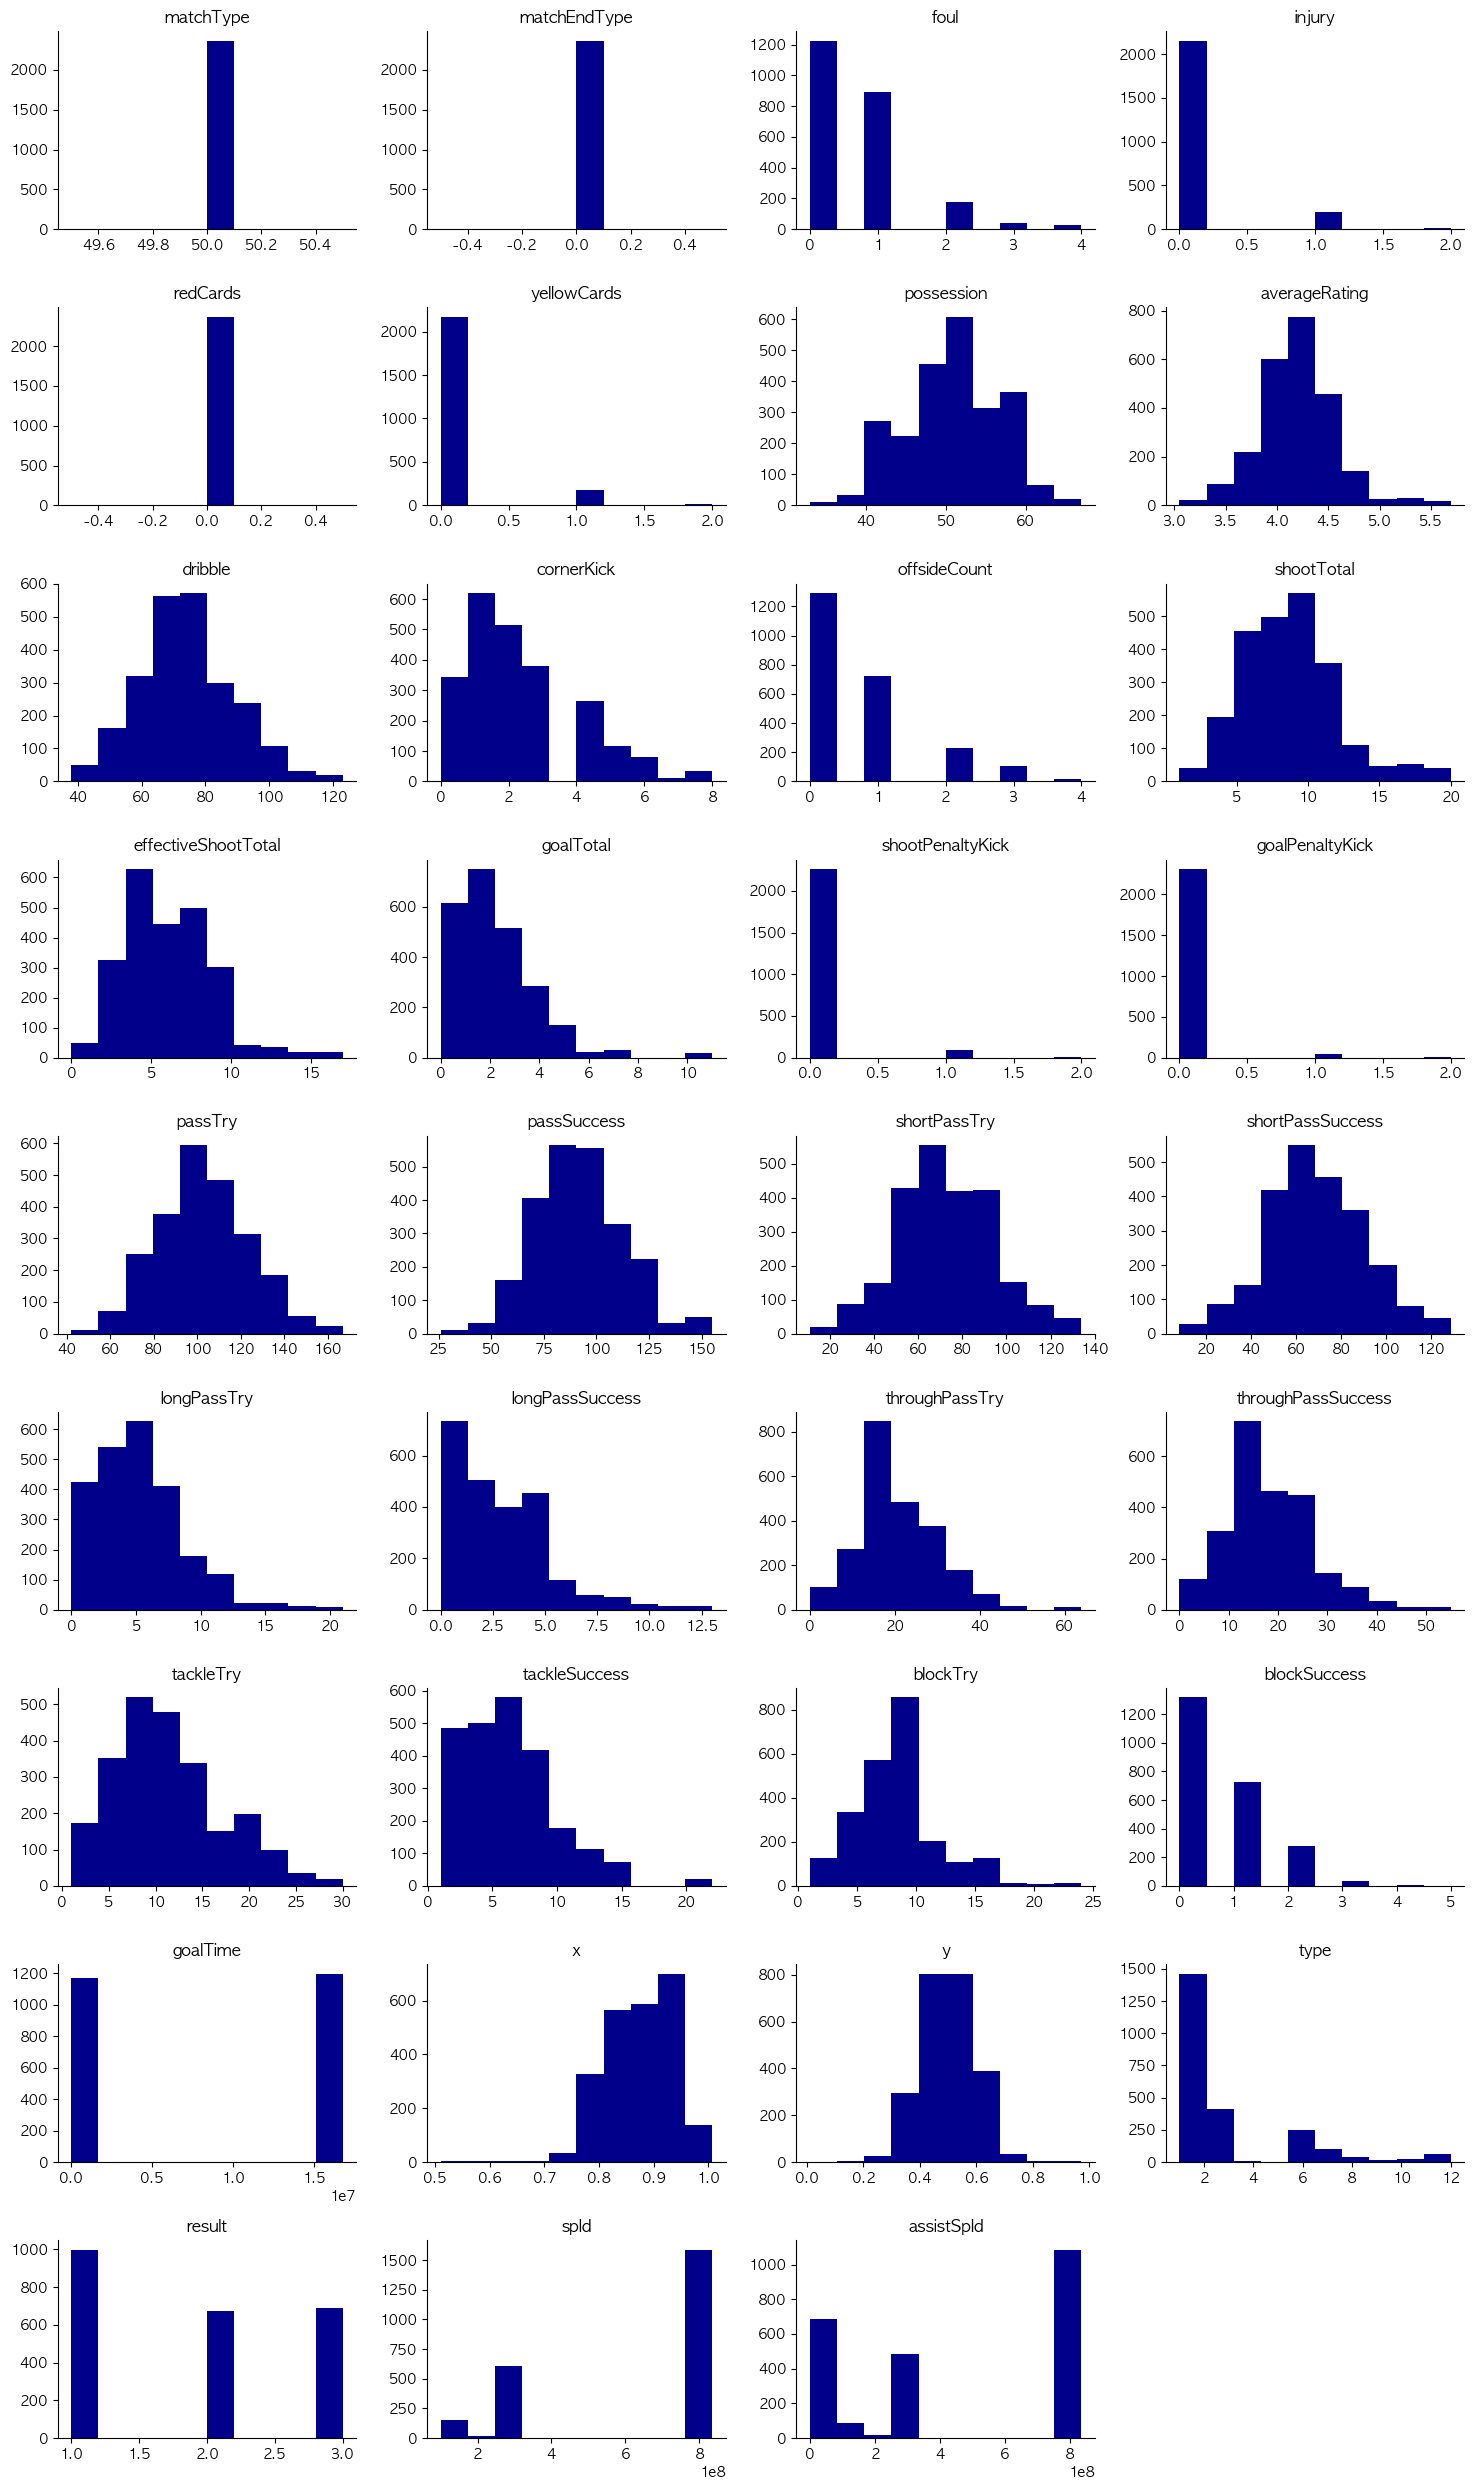

In [8]:
# 데이터 분포 시각화
# 변수 선별
numeric_df = match_df.select_dtypes(include=['number'])
cols = numeric_df.columns

# 서브플롯 생성
fig, axes = plt.subplots(9, 4, figsize=(15, 25))
axes = axes.flatten()

# 각 컬럼에 대해 히스토그램 그리기
for i, column in enumerate(cols):
    axes[i].hist(numeric_df[column].dropna(), color='darkblue', alpha=1)
    axes[i].set_title(column)
    axes[i].grid(axis='x', linestyle=':', color='darkgrey')
    axes[i].grid(axis='x')
    axes[i].spines[['top','right']].set_visible(False)

# 빈 서브플롯 숨기기
for j in range(len(cols), len(axes)):
    axes[j].axis("off")

# 레이아웃 조정 및 출력
plt.tight_layout()
plt.show()

> 결론
- spId, assistSpId는 선수 고유 ID
- goalTime의 max값이 3분위수와 차이가 많이 난다.
- 연속형 변수 중, goalTime을 제외하고는 특별한 이상치가 기술 통계량에서는 확인되지 않는다.
- matchResult는 승리 여부로, 범주형 변수이자 머신러닝 모델의 종속변수가 된다.(이진수가 아닌 '승','패'로 object 타입으로 저장되어 있다.)
- Try와 Success 데이터를 통해 성공확률을 도출할 수 있다.(ex. 패스, 숏패스, 롱패스, 스루패스, 태클 등)

### 2. 데이터 전처리

#### ㄴ 결측값, 중복값 처리 확인
- Airflow를 활용한 ETL 파이프라인 구축하여 결측치, 중복값 처리 완료
- 확인만 하고 넘어간다.

In [9]:
# 결측값 확인
match_df.isna().sum()

matchId                0
matchDate              0
matchType              0
ouid                   0
nickname               0
matchResult            0
matchEndType           0
foul                   0
injury                 0
redCards               0
yellowCards            0
possession             0
averageRating          0
dribble                0
cornerKick             0
offsideCount           0
shootTotal             0
effectiveShootTotal    0
goalTotal              0
shootPenaltyKick       0
goalPenaltyKick        0
passTry                0
passSuccess            0
shortPassTry           0
shortPassSuccess       0
longPassTry            0
longPassSuccess        0
throughPassTry         0
throughPassSuccess     0
tackleTry              0
tackleSuccess          0
blockTry               0
blockSuccess           0
goalTime               0
x                      0
y                      0
type                   0
result                 0
spId                   0
assist                 0


#### ㄴ 중복값 처리

- 데이터는 골 기준으로 ROW가 생성되고 있다.
- 한 경기에 여러 골이 발생하므로 matchId는 중복값 발생
- 따라서 식별자로 사용할 수 없으므로 모든 행에 대해서 중복값이 있는지 체크한다.

In [10]:
# 중복값 확인
match_df.duplicated().sum()

np.int64(0)

- 득점과 관련된 데이터(득점 슛 위치 좌표, 슛 유형, 득점 시간, 득점 선수, 어시스트 선수)는 모델 생성에 활용하지 않고, 따로 세부 분석을 통해 인사이트를 도출하기로 한다.
    - ROW를 경기 단위로 생성하기 위함

In [11]:
match_df.to_csv('./data/match_data.csv', encoding='utf-8-sig', index=False)

In [12]:
# 데이터 누수 방지를 위해 데이터 프레임 복제
preprocessed_df = match_df.copy()

# 득점과 관련된 변수 및 'ouid' 삭제
preprocessed_df = preprocessed_df.drop(columns=['goalTime', 'x', 'y', 'type','result', 'spId', 'assist', 'assistSpId', 'hitPost', 'inPenalty'])

In [13]:
# 변수 삭제 확인
preprocessed_df.columns

Index(['matchId', 'matchDate', 'matchType', 'ouid', 'nickname', 'matchResult',
       'matchEndType', 'foul', 'injury', 'redCards', 'yellowCards',
       'possession', 'averageRating', 'dribble', 'cornerKick', 'offsideCount',
       'shootTotal', 'effectiveShootTotal', 'goalTotal', 'shootPenaltyKick',
       'goalPenaltyKick', 'passTry', 'passSuccess', 'shortPassTry',
       'shortPassSuccess', 'longPassTry', 'longPassSuccess', 'throughPassTry',
       'throughPassSuccess', 'tackleTry', 'tackleSuccess', 'blockTry',
       'blockSuccess'],
      dtype='object')

In [14]:
# 데이터 확인
print(preprocessed_df.shape)
preprocessed_df.head()

(2366, 33)


,matchId,matchDate,matchType,ouid,nickname,matchResult,matchEndType,foul,injury,redCards,...,shortPassTry,shortPassSuccess,longPassTry,longPassSuccess,throughPassTry,throughPassSuccess,tackleTry,tackleSuccess,blockTry,blockSuccess
0,67e5abd6293b2e29d79b74f4,2025-03-27T19:59:51,50,78bd4904e360e8f15281c765ad9069e1,김진효,무,0,0,0,0,...,127,124,4,3,22,16,3,3,11,1
1,67e5abd6293b2e29d79b74f4,2025-03-27T19:59:51,50,78bd4904e360e8f15281c765ad9069e1,김진효,무,0,0,0,0,...,127,124,4,3,22,16,3,3,11,1
2,67e5abd6293b2e29d79b74f4,2025-03-27T19:59:51,50,78bd4904e360e8f15281c765ad9069e1,김진효,무,0,0,0,0,...,127,124,4,3,22,16,3,3,11,1
3,67e5abd6293b2e29d79b74f4,2025-03-27T19:59:51,50,78bd4904e360e8f15281c765ad9069e1,김진효,무,0,0,0,0,...,127,124,4,3,22,16,3,3,11,1
4,67e5abd6293b2e29d79b74f4,2025-03-27T19:59:51,50,78bd4904e360e8f15281c765ad9069e1,김진효,무,0,0,0,0,...,127,124,4,3,22,16,3,3,11,1


#### (*)새로운 데이터 테이블 생성 - ouid로 그룹핑
- 유저별로 매치 디테일 정보와 승, 패 여부가 집계되어야 모델을 개발할 수 있기 때문에 matchId, ouid기준으로 그룹핑 진행(matchId는 날짜와 경기결과 컬럼 merge할때만 활용)
    - 매치별 유저별로 고유 데이터 집계(같은 매치에서 승, 패 유저가 나오기 때문)
- Airflow ETL파이프라인에서 matchEndType값이 0인 데이터(정상종료 매치)만 남겼으므로 확인하고 넘어간다.
- 'matchId', 'nickname','matchType' 삭제 : 분석에 미활용
- ouid당 하나의 값을 가지는 데이터들 : 'matchDate', 'matchResult'
- 나머지 컬럼은 평균으로 집계해야 하나의 유저가 해당 경기에서 기록한 데이터가 된다.(현재는 골단위로 ROW가 집계되어 있어 골 관련 컬럼을 제외하고 동일한 경기 데이터가 중복 집계되어 있음)

In [15]:
# 몰수승, 몰수패는 정상적으로 종료되지 않은 매치이므로 제외한다.('matchEndType' == 0인 경우가 정상)
print(preprocessed_df['matchEndType'].unique())
preprocessed_df['matchEndType'].value_counts()

[0]


matchEndType
0    2366
Name: count, dtype: int64

In [16]:
# 합계로 산출해야하는 변수들
match_group_mean_df = preprocessed_df.groupby(['matchId','ouid'])[[
        'foul', 'injury', 'redCards', 'yellowCards','dribble', 'cornerKick', 'offsideCount',
       'shootTotal', 'effectiveShootTotal', 'goalTotal', 'shootPenaltyKick',
       'goalPenaltyKick', 'passTry', 'passSuccess', 'shortPassTry',
       'shortPassSuccess', 'longPassTry', 'longPassSuccess', 'throughPassTry',
       'throughPassSuccess', 'tackleTry', 'tackleSuccess', 'blockTry', 'blockSuccess','possession', 'averageRating']].mean()
match_group_mean_df = match_group_mean_df.reset_index()

print(match_group_mean_df.shape)
match_group_mean_df.head()

(327, 28)


,matchId,ouid,foul,injury,redCards,yellowCards,dribble,cornerKick,offsideCount,shootTotal,...,longPassTry,longPassSuccess,throughPassTry,throughPassSuccess,tackleTry,tackleSuccess,blockTry,blockSuccess,possession,averageRating
0,67e5ab6c26956677381da20f,00bb68e0fa9a9f7cb1665b32dd8069b7,1.0,0.0,0.0,0.0,64.0,3.0,0.0,3.0,...,8.0,4.0,16.0,16.0,17.0,9.0,5.0,1.0,44.0,3.63333
1,67e5ab6c26956677381da20f,b732daf0b96fc9256262fb36cb72c1bc,0.0,0.0,0.0,0.0,75.0,1.0,1.0,14.0,...,8.0,5.0,26.0,25.0,13.0,8.0,5.0,0.0,56.0,4.59444
2,67e5ab6d0b020281e49f1496,7fe7ffb96f2154e14825d674841ff270,0.0,0.0,0.0,0.0,80.0,2.0,0.0,7.0,...,5.0,4.0,19.0,17.0,6.0,4.0,8.0,1.0,58.0,4.21667
3,67e5ab6d0b020281e49f1496,a184d3be0a42e0978644eb62b3b41ff5,1.0,0.0,0.0,0.0,68.0,1.0,0.0,8.0,...,2.0,1.0,22.0,18.0,21.0,9.0,6.0,0.0,42.0,3.82778
4,67e5ab6edc4cb4e86e4f9236,eb36555d4d460edc57ee20b782723388,0.0,0.0,0.0,0.0,72.0,0.0,1.0,6.0,...,4.0,1.0,15.0,13.0,4.0,1.0,15.0,2.0,44.0,4.07222


In [17]:
# matchDate와 matchResult 결과 컬럼
date_result_tmp_df = preprocessed_df.drop_duplicates(subset=['matchId','ouid'],keep='last')
date_result_tmp_df = date_result_tmp_df[['matchId','ouid', 'matchDate','matchResult']]
date_result_tmp_df

,matchId,ouid,matchDate,matchResult
7,67e5abd6293b2e29d79b74f4,78bd4904e360e8f15281c765ad9069e1,2025-03-27T19:59:51,무
13,67e5abd6293b2e29d79b74f4,9d4d64dbc5059a01ccc444e5e689afb3,2025-03-27T19:59:51,무
21,67e5abcbe8468deaf6fec235,8d02ebfde90f0a506c8661c50652e746,2025-03-27T19:59:51,승
31,67e5abcbe8468deaf6fec235,576ee2848ba44a7b0215508aa49c8058,2025-03-27T19:59:51,패
48,67e5abb4a31a3191e1329645,936706df699f3defa8ae2461340c1bd0,2025-03-27T19:59:39,승
...,...,...,...,...
2334,67edb024e3434b52f40ad645,4b7a308adbc80295df75568d1831974f,2025-04-02T21:56:54,패
2343,67edb01d9a59beefe935fa6d,44f372d5cf324675cdf80ab1fd07ab62,2025-04-02T21:57:25,승
2352,67edb01d9a59beefe935fa6d,4e17c050be2e65051a9d81145ce7455c,2025-04-02T21:57:25,패
2360,67edb01c186e1ede8ceffe0e,88c5044e620fdf50ee5f3b53ebf56c4b,2025-04-02T21:56:31,패


- matchDate, matchResult 병합

In [18]:
# 최종 데이터 생성
match_merge_df = pd.merge(match_group_mean_df, date_result_tmp_df, how='inner', on=['matchId','ouid'])
print(match_merge_df.shape)
match_merge_df.head()

(327, 30)


,matchId,ouid,foul,injury,redCards,yellowCards,dribble,cornerKick,offsideCount,shootTotal,...,throughPassTry,throughPassSuccess,tackleTry,tackleSuccess,blockTry,blockSuccess,possession,averageRating,matchDate,matchResult
0,67e5ab6c26956677381da20f,00bb68e0fa9a9f7cb1665b32dd8069b7,1.0,0.0,0.0,0.0,64.0,3.0,0.0,3.0,...,16.0,16.0,17.0,9.0,5.0,1.0,44.0,3.63333,2025-03-27T19:59:05,패
1,67e5ab6c26956677381da20f,b732daf0b96fc9256262fb36cb72c1bc,0.0,0.0,0.0,0.0,75.0,1.0,1.0,14.0,...,26.0,25.0,13.0,8.0,5.0,0.0,56.0,4.59444,2025-03-27T19:59:05,승
2,67e5ab6d0b020281e49f1496,7fe7ffb96f2154e14825d674841ff270,0.0,0.0,0.0,0.0,80.0,2.0,0.0,7.0,...,19.0,17.0,6.0,4.0,8.0,1.0,58.0,4.21667,2025-03-27T19:58:36,승
3,67e5ab6d0b020281e49f1496,a184d3be0a42e0978644eb62b3b41ff5,1.0,0.0,0.0,0.0,68.0,1.0,0.0,8.0,...,22.0,18.0,21.0,9.0,6.0,0.0,42.0,3.82778,2025-03-27T19:58:36,패
4,67e5ab6edc4cb4e86e4f9236,eb36555d4d460edc57ee20b782723388,0.0,0.0,0.0,0.0,72.0,0.0,1.0,6.0,...,15.0,13.0,4.0,1.0,15.0,2.0,44.0,4.07222,2025-03-27T19:59:02,패


In [19]:
match_merge_df.to_csv('./data/match_merge_data.csv', encoding='utf-8-sig', index=False)

In [20]:
# matchId 삭제
match_merge_df = match_merge_df.drop(columns=['matchId'])
match_merge_df.head()

,ouid,foul,injury,redCards,yellowCards,dribble,cornerKick,offsideCount,shootTotal,effectiveShootTotal,...,throughPassTry,throughPassSuccess,tackleTry,tackleSuccess,blockTry,blockSuccess,possession,averageRating,matchDate,matchResult
0,00bb68e0fa9a9f7cb1665b32dd8069b7,1.0,0.0,0.0,0.0,64.0,3.0,0.0,3.0,2.0,...,16.0,16.0,17.0,9.0,5.0,1.0,44.0,3.63333,2025-03-27T19:59:05,패
1,b732daf0b96fc9256262fb36cb72c1bc,0.0,0.0,0.0,0.0,75.0,1.0,1.0,14.0,9.0,...,26.0,25.0,13.0,8.0,5.0,0.0,56.0,4.59444,2025-03-27T19:59:05,승
2,7fe7ffb96f2154e14825d674841ff270,0.0,0.0,0.0,0.0,80.0,2.0,0.0,7.0,6.0,...,19.0,17.0,6.0,4.0,8.0,1.0,58.0,4.21667,2025-03-27T19:58:36,승
3,a184d3be0a42e0978644eb62b3b41ff5,1.0,0.0,0.0,0.0,68.0,1.0,0.0,8.0,7.0,...,22.0,18.0,21.0,9.0,6.0,0.0,42.0,3.82778,2025-03-27T19:58:36,패
4,eb36555d4d460edc57ee20b782723388,0.0,0.0,0.0,0.0,72.0,0.0,1.0,6.0,4.0,...,15.0,13.0,4.0,1.0,15.0,2.0,44.0,4.07222,2025-03-27T19:59:02,패


#### ㄴ 이상치 처리

In [21]:
# 숫자형 변수
numeric_cols = match_merge_df.select_dtypes('number').columns
numeric_cols

Index(['foul', 'injury', 'redCards', 'yellowCards', 'dribble', 'cornerKick',
       'offsideCount', 'shootTotal', 'effectiveShootTotal', 'goalTotal',
       'shootPenaltyKick', 'goalPenaltyKick', 'passTry', 'passSuccess',
       'shortPassTry', 'shortPassSuccess', 'longPassTry', 'longPassSuccess',
       'throughPassTry', 'throughPassSuccess', 'tackleTry', 'tackleSuccess',
       'blockTry', 'blockSuccess', 'possession', 'averageRating'],
      dtype='object')

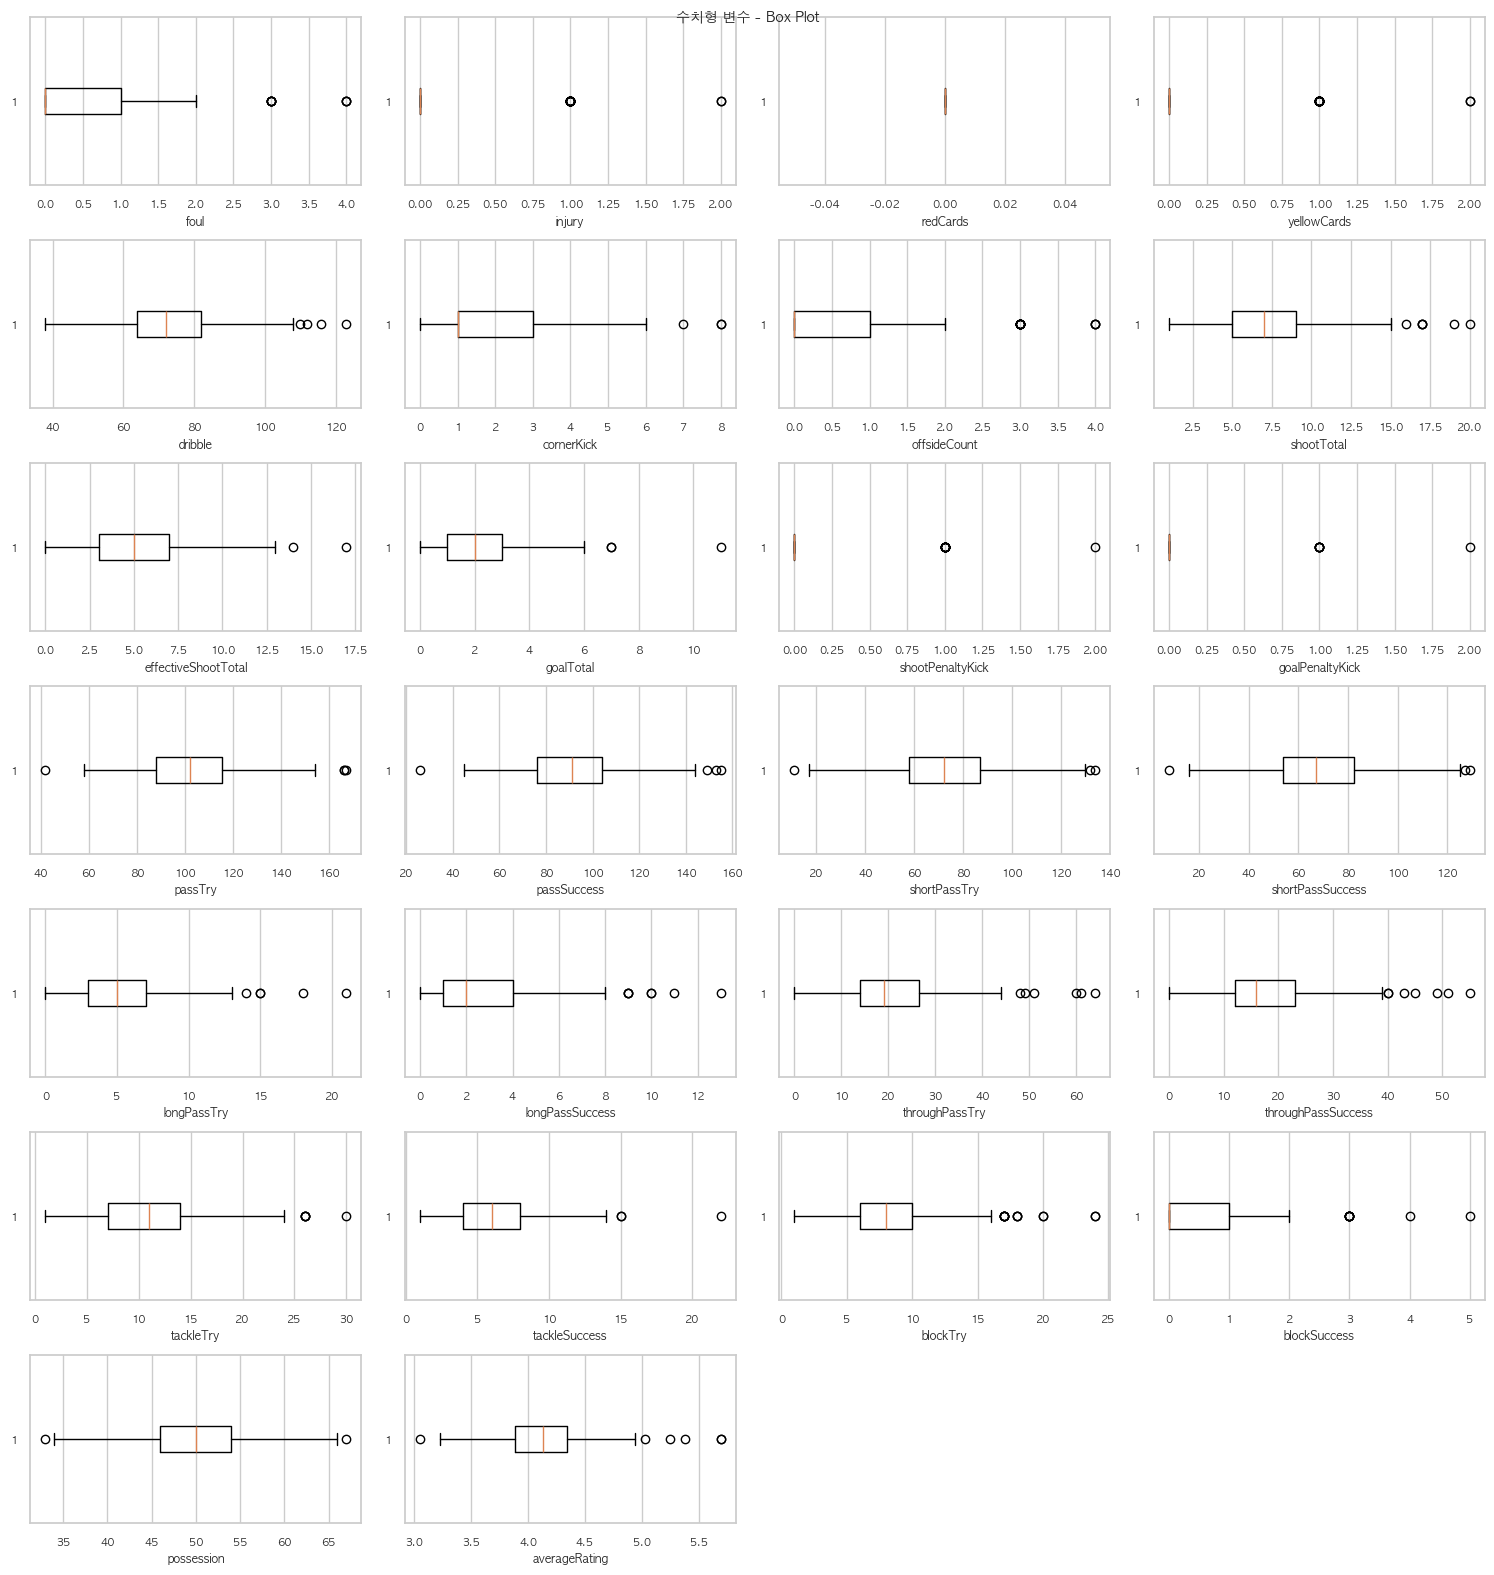

In [22]:
# 이상치 확인할 변수 선택
outlier_cols = numeric_cols

# 컬럼별 이상치 시각화
sns.set_theme(style='whitegrid',rc={'figure.figsize':(10,6)}, font_scale=0.7, font='AppleGothic')

fig, axes = plt.subplots(7,4,figsize=(15, 16))
axes = axes.flatten()

for i, col in enumerate(outlier_cols):
    axes[i].boxplot(match_merge_df[col],  vert=False)
    axes[i].set_xlabel(f'{col}')
    axes[i].set_xlabel(f'{col}')
    axes[i].grid(axis='y')

# 빈 서브플롯 숨기기
for j in range(len(outlier_cols), len(axes)):
    axes[j].axis("off")

fig.suptitle('수치형 변수 - Box Plot')

fig.tight_layout()
fig.show()

In [23]:
# 이상치 개수 확인
for col in outlier_cols:
  q1 = match_merge_df[col].quantile(0.25)
  q3 = match_merge_df[col].quantile(0.75)
  iqr = q3-q1
  outlier_count = len(match_merge_df[(match_merge_df[col] < (q1 - (1.5*iqr)))|(match_merge_df[col] > (q3 + (1.5*iqr)))])

  print(f"{col} - 이상치 개수: {outlier_count}", '/', f"비율: {round((outlier_count/len(match_merge_df))*100,2)}%")

foul - 이상치 개수: 9 / 비율: 2.75%
injury - 이상치 개수: 27 / 비율: 8.26%
redCards - 이상치 개수: 0 / 비율: 0.0%
yellowCards - 이상치 개수: 25 / 비율: 7.65%
dribble - 이상치 개수: 4 / 비율: 1.22%
cornerKick - 이상치 개수: 3 / 비율: 0.92%
offsideCount - 이상치 개수: 14 / 비율: 4.28%
shootTotal - 이상치 개수: 6 / 비율: 1.83%
effectiveShootTotal - 이상치 개수: 2 / 비율: 0.61%
goalTotal - 이상치 개수: 3 / 비율: 0.92%
shootPenaltyKick - 이상치 개수: 14 / 비율: 4.28%
goalPenaltyKick - 이상치 개수: 7 / 비율: 2.14%
passTry - 이상치 개수: 4 / 비율: 1.22%
passSuccess - 이상치 개수: 4 / 비율: 1.22%
shortPassTry - 이상치 개수: 3 / 비율: 0.92%
shortPassSuccess - 이상치 개수: 3 / 비율: 0.92%
longPassTry - 이상치 개수: 5 / 비율: 1.53%
longPassSuccess - 이상치 개수: 7 / 비율: 2.14%
throughPassTry - 이상치 개수: 6 / 비율: 1.83%
throughPassSuccess - 이상치 개수: 7 / 비율: 2.14%
tackleTry - 이상치 개수: 5 / 비율: 1.53%
tackleSuccess - 이상치 개수: 3 / 비율: 0.92%
blockTry - 이상치 개수: 13 / 비율: 3.98%
blockSuccess - 이상치 개수: 9 / 비율: 2.75%
possession - 이상치 개수: 2 / 비율: 0.61%
averageRating - 이상치 개수: 6 / 비율: 1.83%


> 결론

<특이사항>
- injury : 부상 수, 부상은 인게임에서 잘 발생하지 않아 대부분의 데이터가 0에 몰려 있어 사분위수로 이상치 탐지시 1과 같은 정상값도 이상치로 간주됨.(이상치 처리 X)
- foul : 파울 수, 대부분의 데이터가 0에 몰려 있어 사분위수로 이상치 탐지시 1, 2와 같은 정상값도 이상치로 간주됨.(이상치 처리 X)
- yellowCards, redCards : 대부분의 데이터가 0에 몰려 있어 사분위수로 이상치 탐지시 1과 같은 정상값도 이상치로 간주됨.(이상치 처리 X)
- goalTotal : 현실적으로 경기당 한 팀이 7~8개의 득점을 낼 수 있으므로(현실적인 수치이므로)
- averageRating : 경기 사후에 매겨지는 경기 평점이므로 경기 결과에 영향을 주지 않는다. 이상치 처리 필요성 X
- shootTotal : 총 슈팅 수가 1인 경기 또한 공격이 제대로 진행되지 않은 경기로써, 분석할 가치가 있으므로 이상치 처리 X
- shootPenaltyKick : 대부분의 경기에서 페널티킥이 발생하지 않으므로 1이 이상치로 관찰되는 것이며, 실질적인 이상치는 아니다.
- goalPenaltyKick : 위와 동일
- injury, cornerKick, longPassSuccess를 제외하고 모두 5%내외로 이상치 적게 발생

<처리 예정 사항>

- injury, cornerKick, longPassSuccess도 10%내외로 이상치가 많지 않고, 사분위수 이상치 탐지 범위 내에 들지 않은 데이터가 인사이트를 제공해줄 수 있다.
- 따라서 데이터를 살리면서 이상치 영향을 감소시키기 위해 `KNN알고리즘으로 이웃 평균치로 대치`
- 단, 위 <특이사항>에서 이상치로 처리하지 않는다고 기재한 변수는 제외하고 진행한다.(injury, foul, averageRating, shootTotal, shootPenaltyKick, goalPenaltyKick)

- KNN 활용 이상치 처리

In [212]:
try_success_cols = ['dribble', 'cornerKick','offsideCount','shootTotal','effectiveShootTotal','goalTotal', 'shortPassTry', 'shortPassSuccess', 'longPassTry', 'longPassSuccess' ,'throughPassTry','throughPassSuccess','tackleTry','tackleSuccess','blockTry','blockSuccess']

# 데이터 누수 방지를 위해 데이터프레임 복제
outlier_processed_df = match_merge_df.copy()

# KNN 모델을 사용하여 이웃 계산
knn = NearestNeighbors(n_neighbors=5)  # n_neighbors 값을 직접 설정

# 데이터로 학습
knn.fit(outlier_processed_df[try_success_cols])

# 각 샘플에 대해 가장 가까운 이웃까지의 거리 계산
distances, indices = knn.kneighbors(outlier_processed_df[try_success_cols])

# distance_threshold 값을 결정하는 방법 (상위 90% 거리값 기준)
distance_threshold = np.percentile(distances[:, -1], 90)

# 이상치 판별
outliers = distances[:, -1] > distance_threshold

# 이상치 대치 (예: 가까운 이웃의 평균값으로 대체)
for i in range(outlier_processed_df[try_success_cols].shape[0]):
    if outliers[i]:
        # 이상치인 경우, 해당 샘플의 이웃들의 평균값으로 대체
        outlier_processed_df[try_success_cols].iloc[i] = np.mean(outlier_processed_df[try_success_cols].iloc[indices[i]], axis=0)

# 결과 출력
print(f"감지된 이상치 개수: {sum(outliers)}")

감지된 이상치 개수: 33


In [213]:
# 범주형 데이터 확인 - 기술통계량
outlier_processed_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ouid,327,326,eb36555d4d460edc57ee20b782723388,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
foul,327.0,NaN,NaN,NaN,0.611621,0.790426,0.0,0.0,0.0,1.0,4.0
injury,327.0,NaN,NaN,NaN,0.088685,0.305512,0.0,0.0,0.0,0.0,2.0
redCards,327.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
yellowCards,327.0,NaN,NaN,NaN,0.082569,0.297075,0.0,0.0,0.0,0.0,2.0
dribble,327.0,NaN,NaN,NaN,73.415902,14.652146,38.0,64.0,72.0,82.0,123.0
cornerKick,327.0,NaN,NaN,NaN,1.819572,1.633952,0.0,1.0,1.0,3.0,8.0
offsideCount,327.0,NaN,NaN,NaN,0.633028,0.861521,0.0,0.0,0.0,1.0,4.0
shootTotal,327.0,NaN,NaN,NaN,7.076453,3.340167,1.0,5.0,7.0,9.0,20.0
effectiveShootTotal,327.0,NaN,NaN,NaN,5.061162,2.59942,0.0,3.0,5.0,7.0,17.0


#### ㄴ 데이터 인코딩

In [214]:
# 데이터 프레임 복제
encoded_df = outlier_processed_df.copy()
encoded_df.head()

,ouid,foul,injury,redCards,yellowCards,dribble,cornerKick,offsideCount,shootTotal,effectiveShootTotal,...,throughPassTry,throughPassSuccess,tackleTry,tackleSuccess,blockTry,blockSuccess,possession,averageRating,matchDate,matchResult
0,00bb68e0fa9a9f7cb1665b32dd8069b7,1.0,0.0,0.0,0.0,64.0,3.0,0.0,3.0,2.0,...,16.0,16.0,17.0,9.0,5.0,1.0,44.0,3.63333,2025-03-27T19:59:05,패
1,b732daf0b96fc9256262fb36cb72c1bc,0.0,0.0,0.0,0.0,75.0,1.0,1.0,14.0,9.0,...,26.0,25.0,13.0,8.0,5.0,0.0,56.0,4.59444,2025-03-27T19:59:05,승
2,7fe7ffb96f2154e14825d674841ff270,0.0,0.0,0.0,0.0,80.0,2.0,0.0,7.0,6.0,...,19.0,17.0,6.0,4.0,8.0,1.0,58.0,4.21667,2025-03-27T19:58:36,승
3,a184d3be0a42e0978644eb62b3b41ff5,1.0,0.0,0.0,0.0,68.0,1.0,0.0,8.0,7.0,...,22.0,18.0,21.0,9.0,6.0,0.0,42.0,3.82778,2025-03-27T19:58:36,패
4,eb36555d4d460edc57ee20b782723388,0.0,0.0,0.0,0.0,72.0,0.0,1.0,6.0,4.0,...,15.0,13.0,4.0,1.0,15.0,2.0,44.0,4.07222,2025-03-27T19:59:02,패


In [215]:
# matchDate 컬럼 삭제
outlier_processed_df = outlier_processed_df.drop(columns='matchDate')
outlier_processed_df.head()

,ouid,foul,injury,redCards,yellowCards,dribble,cornerKick,offsideCount,shootTotal,effectiveShootTotal,...,longPassSuccess,throughPassTry,throughPassSuccess,tackleTry,tackleSuccess,blockTry,blockSuccess,possession,averageRating,matchResult
0,00bb68e0fa9a9f7cb1665b32dd8069b7,1.0,0.0,0.0,0.0,64.0,3.0,0.0,3.0,2.0,...,4.0,16.0,16.0,17.0,9.0,5.0,1.0,44.0,3.63333,패
1,b732daf0b96fc9256262fb36cb72c1bc,0.0,0.0,0.0,0.0,75.0,1.0,1.0,14.0,9.0,...,5.0,26.0,25.0,13.0,8.0,5.0,0.0,56.0,4.59444,승
2,7fe7ffb96f2154e14825d674841ff270,0.0,0.0,0.0,0.0,80.0,2.0,0.0,7.0,6.0,...,4.0,19.0,17.0,6.0,4.0,8.0,1.0,58.0,4.21667,승
3,a184d3be0a42e0978644eb62b3b41ff5,1.0,0.0,0.0,0.0,68.0,1.0,0.0,8.0,7.0,...,1.0,22.0,18.0,21.0,9.0,6.0,0.0,42.0,3.82778,패
4,eb36555d4d460edc57ee20b782723388,0.0,0.0,0.0,0.0,72.0,0.0,1.0,6.0,4.0,...,1.0,15.0,13.0,4.0,1.0,15.0,2.0,44.0,4.07222,패


##### 파생변수 생성

1) 평일/주말

In [216]:
# datetime 형식으로 변환
encoded_df['matchDate'] = pd.to_datetime(encoded_df['matchDate'])

# 평일/주말
encoded_df['weekend'] = encoded_df['matchDate'].dt.weekday.map(lambda x: '평일' if x < 5 else '주말')

# # 요일
# encoded_df['weekday'] = encoded_df['matchDate'].dt.day_name()

# 시간대(0~23)
# encoded_df['hour'] = encoded_df['matchDate'].dt.hour

# 데이터 확인
print(encoded_df.shape)
encoded_df.head()

(327, 30)


,ouid,foul,injury,redCards,yellowCards,dribble,cornerKick,offsideCount,shootTotal,effectiveShootTotal,...,throughPassSuccess,tackleTry,tackleSuccess,blockTry,blockSuccess,possession,averageRating,matchDate,matchResult,weekend
0,00bb68e0fa9a9f7cb1665b32dd8069b7,1.0,0.0,0.0,0.0,64.0,3.0,0.0,3.0,2.0,...,16.0,17.0,9.0,5.0,1.0,44.0,3.63333,2025-03-27 19:59:05,패,평일
1,b732daf0b96fc9256262fb36cb72c1bc,0.0,0.0,0.0,0.0,75.0,1.0,1.0,14.0,9.0,...,25.0,13.0,8.0,5.0,0.0,56.0,4.59444,2025-03-27 19:59:05,승,평일
2,7fe7ffb96f2154e14825d674841ff270,0.0,0.0,0.0,0.0,80.0,2.0,0.0,7.0,6.0,...,17.0,6.0,4.0,8.0,1.0,58.0,4.21667,2025-03-27 19:58:36,승,평일
3,a184d3be0a42e0978644eb62b3b41ff5,1.0,0.0,0.0,0.0,68.0,1.0,0.0,8.0,7.0,...,18.0,21.0,9.0,6.0,0.0,42.0,3.82778,2025-03-27 19:58:36,패,평일
4,eb36555d4d460edc57ee20b782723388,0.0,0.0,0.0,0.0,72.0,0.0,1.0,6.0,4.0,...,13.0,4.0,1.0,15.0,2.0,44.0,4.07222,2025-03-27 19:59:02,패,평일


In [217]:
# # 시간대 인코딩 확인
# encoded_df['hour'].value_counts()

In [218]:
# matchDate 컬럼 삭제
encoded_df = encoded_df.drop(columns='matchDate')
encoded_df.head()

,ouid,foul,injury,redCards,yellowCards,dribble,cornerKick,offsideCount,shootTotal,effectiveShootTotal,...,throughPassTry,throughPassSuccess,tackleTry,tackleSuccess,blockTry,blockSuccess,possession,averageRating,matchResult,weekend
0,00bb68e0fa9a9f7cb1665b32dd8069b7,1.0,0.0,0.0,0.0,64.0,3.0,0.0,3.0,2.0,...,16.0,16.0,17.0,9.0,5.0,1.0,44.0,3.63333,패,평일
1,b732daf0b96fc9256262fb36cb72c1bc,0.0,0.0,0.0,0.0,75.0,1.0,1.0,14.0,9.0,...,26.0,25.0,13.0,8.0,5.0,0.0,56.0,4.59444,승,평일
2,7fe7ffb96f2154e14825d674841ff270,0.0,0.0,0.0,0.0,80.0,2.0,0.0,7.0,6.0,...,19.0,17.0,6.0,4.0,8.0,1.0,58.0,4.21667,승,평일
3,a184d3be0a42e0978644eb62b3b41ff5,1.0,0.0,0.0,0.0,68.0,1.0,0.0,8.0,7.0,...,22.0,18.0,21.0,9.0,6.0,0.0,42.0,3.82778,패,평일
4,eb36555d4d460edc57ee20b782723388,0.0,0.0,0.0,0.0,72.0,0.0,1.0,6.0,4.0,...,15.0,13.0,4.0,1.0,15.0,2.0,44.0,4.07222,패,평일


2) 패스/슛/태클/블록 성공률

- 패스

In [219]:
# 총 패스
encoded_df['passSucRt'] = (
    encoded_df['passSuccess'] / encoded_df['passTry']
).fillna(0)

# 숏 패스
encoded_df['shortPassSucRt'] = (
    encoded_df['shortPassSuccess'] / encoded_df['shortPassTry']
).fillna(0)

# 롱 패스
encoded_df['longPassSucRt'] = (
    encoded_df['longPassSuccess'] / encoded_df['longPassTry']
).fillna(0)

# 스루 패스
encoded_df['throughPassSucRt'] = (
    encoded_df['throughPassSuccess'] / encoded_df['throughPassTry']
).fillna(0)

- 유효슈팅율

In [220]:
# 유효슈팅율
encoded_df['shootAccuracy'] = (
    encoded_df['effectiveShootTotal'] / encoded_df['shootTotal']
).fillna(0)

- 태클

In [221]:
# 태클 성공율
encoded_df['tackleSucRt'] = (
    encoded_df['tackleSuccess'] / encoded_df['tackleTry']
).fillna(0)

- 블록

In [222]:
# 블록 성공율
encoded_df['blockSucRt'] = (
    encoded_df['blockSuccess'] / encoded_df['blockTry']
).fillna(0)

In [223]:
encoded_df.head(3)

,ouid,foul,injury,redCards,yellowCards,dribble,cornerKick,offsideCount,shootTotal,effectiveShootTotal,...,averageRating,matchResult,weekend,passSucRt,shortPassSucRt,longPassSucRt,throughPassSucRt,shootAccuracy,tackleSucRt,blockSucRt
0,00bb68e0fa9a9f7cb1665b32dd8069b7,1.0,0.0,0.0,0.0,64.0,3.0,0.0,3.0,2.0,...,3.63333,패,평일,0.851852,0.887500,0.500,1.000000,0.666667,0.529412,0.200
1,b732daf0b96fc9256262fb36cb72c1bc,0.0,0.0,0.0,0.0,75.0,1.0,1.0,14.0,9.0,...,4.59444,승,평일,0.907216,0.949153,0.625,0.961538,0.642857,0.615385,0.000
2,7fe7ffb96f2154e14825d674841ff270,0.0,0.0,0.0,0.0,80.0,2.0,0.0,7.0,6.0,...,4.21667,승,평일,0.938144,0.985075,0.800,0.894737,0.857143,0.666667,0.125


##### 2) 원핫 인코딩
- EDA 과정에서는 경기 결과는 원핫 인코딩, 모델을 위한 Feature Engineering 과정에서는 트리기반 모델로 학습시킬 것이므로 레이블 인코딩으로 진행한다.

In [224]:
# 범주형 변수 원핫 인코딩 실시
eda_df = encoded_df.copy()

eda_df = pd.get_dummies(eda_df, columns = ['matchResult','weekend'], drop_first=True, dtype = int)

eda_df.head()

,ouid,foul,injury,redCards,yellowCards,dribble,cornerKick,offsideCount,shootTotal,effectiveShootTotal,...,averageRating,passSucRt,shortPassSucRt,longPassSucRt,throughPassSucRt,shootAccuracy,tackleSucRt,blockSucRt,matchResult_승,matchResult_패
0,00bb68e0fa9a9f7cb1665b32dd8069b7,1.0,0.0,0.0,0.0,64.0,3.0,0.0,3.0,2.0,...,3.63333,0.851852,0.887500,0.500,1.000000,0.666667,0.529412,0.200000,0,1
1,b732daf0b96fc9256262fb36cb72c1bc,0.0,0.0,0.0,0.0,75.0,1.0,1.0,14.0,9.0,...,4.59444,0.907216,0.949153,0.625,0.961538,0.642857,0.615385,0.000000,1,0
2,7fe7ffb96f2154e14825d674841ff270,0.0,0.0,0.0,0.0,80.0,2.0,0.0,7.0,6.0,...,4.21667,0.938144,0.985075,0.800,0.894737,0.857143,0.666667,0.125000,1,0
3,a184d3be0a42e0978644eb62b3b41ff5,1.0,0.0,0.0,0.0,68.0,1.0,0.0,8.0,7.0,...,3.82778,0.904762,0.944444,0.500,0.818182,0.875000,0.428571,0.000000,0,1
4,eb36555d4d460edc57ee20b782723388,0.0,0.0,0.0,0.0,72.0,0.0,1.0,6.0,4.0,...,4.07222,0.895349,0.954545,0.250,0.866667,0.666667,0.250000,0.133333,0,1


### 3. 상관관계 분석

- 전체 변수 상관관계 분석

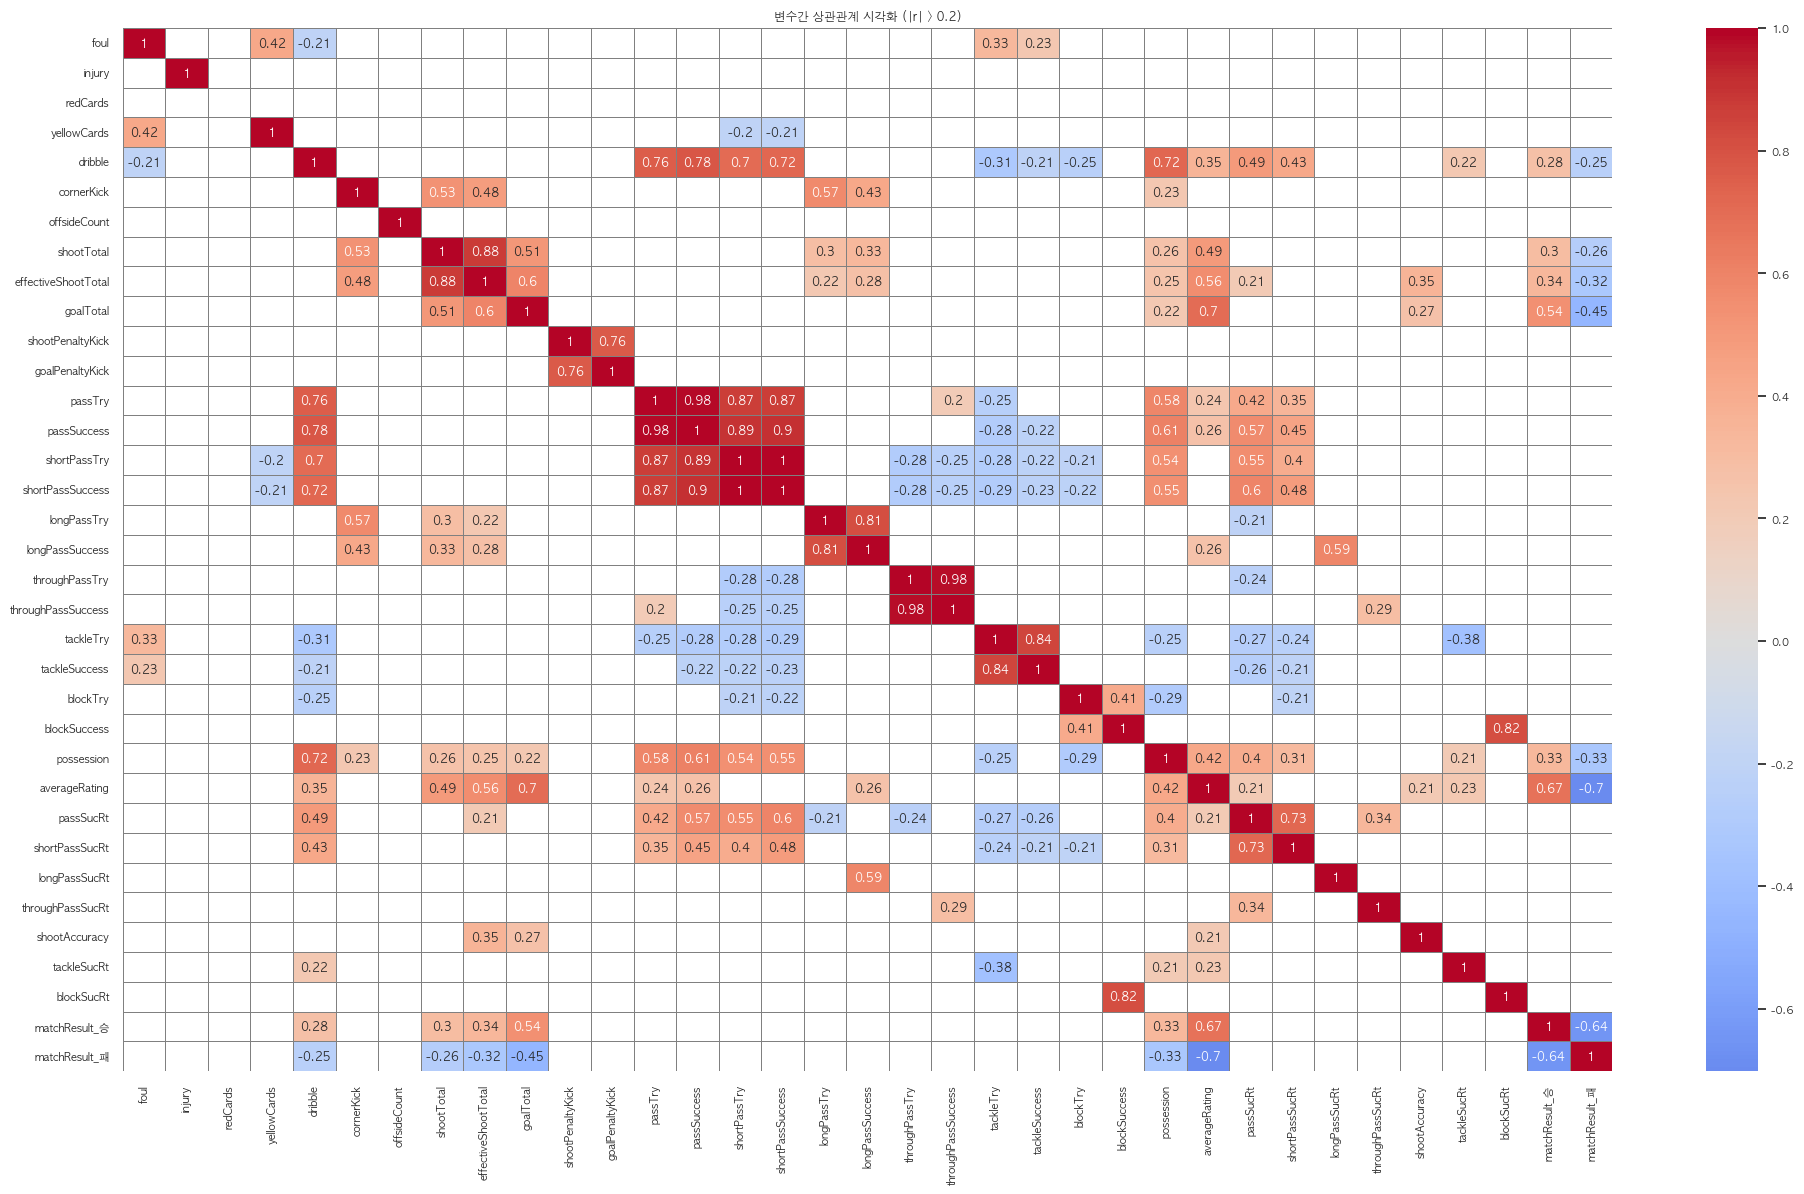

In [225]:
# ouid 제외
corr_df = eda_df.drop(columns='ouid')

# 상관계수 계산
corr_matrix = corr_df.corr()

# 마스킹 조건: -0.2 ~ 0.2 사이 값은 흰색 처리
mask = (corr_matrix < 0.2) & (corr_matrix > -0.2)

# 시각화
sns.set_theme(style='whitegrid', rc={'figure.figsize': (20, 12)}, font_scale=0.7, font='AppleGothic')
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', mask=mask, center=0, linewidths=0.5, linecolor='gray')

plt.title('변수간 상관관계 시각화 (|r| > 0.2)')
plt.grid(False)
plt.tight_layout()
plt.show()

> 전체 변수 상관관계 분석 인사이트 정리

상관계수가 0.3이상이거나 -0.3이하인 관계만 표현

1. 드리블, 점유율, 패스(특히 짧은 패스)는 높은 양의 상관관계 > 티키타카 스타일로 점유율을 지배하는 스타일을 의미
2. 레드카드는 페널티킥, 옐로카드와 높은 양의 상관관계 > 직관적으로 당연함
3. 코너킥은 슈팅, 유효슛, 롱패스와 높은 양의 상관관계 > 코너킥이 유의미한 골찬스를 만든다.
4. 유효슛은 경기 승리, 평균 평점, 태클 성공, 골, 슛, 코너킥과 높은 양의 상관관계 > 유효슛이 경기 승리에 높은 영향을 미칠 것
5. 짧은 패스는 스루패스와 높은 음의 상관관계 > 짧은 패스 축구 스타일과 스루패스 스타일은 대척점인가?
6. 패스 시도와 태클 성공 매우 높은 양의 상관관계 > 총 패스 시도는 짧은 패스와 높은 상관관계, 따라서 짧은 패스를 구사하는 티키타카 스타일 유저는 선수간격이 좁아 태클도 많이 시도하게 되는 것이라 추정된다.


> 눈에 띄는 인사이트

1. 드리블, 점유율, 패스(특히 짧은 패스)는 높은 양의 상관관계
2. 짧은 패스는 스루패스와 높은 음의 상관관계/패스 종류 중에서 전체 패스와 가장 높은 양의 상관관계
3. 패스 시도와 태클 성공 매우 높은 양의 상관관계

#### ㄴ 시각화

- 경기 승리와의 상관관계 분석

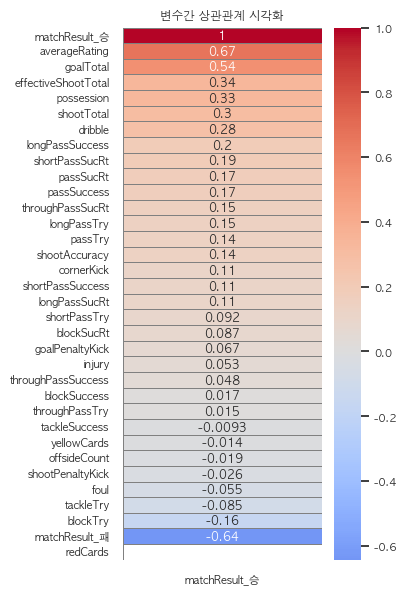

In [180]:
# ouid 제외
corr_df = eda_df.drop(columns='ouid')

# 상관계수 계산
corr_matrix = corr_df.corr()[['matchResult_승']]

# 마스킹 조건: -0.3 ~ 0.3 사이 값은 흰색 처리
#mask = (corr_matrix < 0.3) & (corr_matrix > -0.3)

# 시각화
sns.set_theme(style='whitegrid', rc={'figure.figsize': (4, 6)}, font_scale=0.7, font='AppleGothic')
sns.heatmap(corr_matrix.sort_values(by='matchResult_승', ascending=False), annot=True, cmap='coolwarm', center=0, linewidths=0.5, linecolor='gray')

plt.title('변수간 상관관계 시각화')
plt.grid(False)
plt.tight_layout()
plt.show()

> 인사이트

1. 양의 상관관계: 슛 , 스루패스, 롱패스
2. 음의 상관관계: 슛 , 짧은패스, 부상

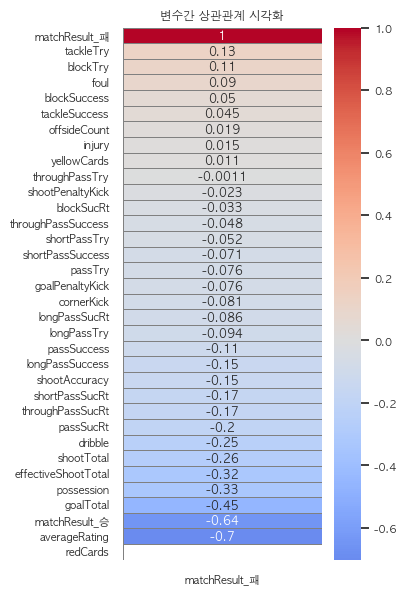

In [181]:
# ouid 제외
corr_df = eda_df.drop(columns='ouid')

# 상관계수 계산
corr_matrix = corr_df.corr()[['matchResult_패']]

# 마스킹 조건: -0.3 ~ 0.3 사이 값은 흰색 처리
#mask = (corr_matrix < 0.3) & (corr_matrix > -0.3)

# 시각화
sns.set_theme(style='whitegrid', rc={'figure.figsize': (4, 6)}, font_scale=0.7, font='AppleGothic')
sns.heatmap(corr_matrix.sort_values(by='matchResult_패', ascending=False), annot=True, cmap='coolwarm', center=0, linewidths=0.5, linecolor='gray')

plt.title('변수간 상관관계 시각화')
plt.grid(False)
plt.tight_layout()
plt.show()

#### ㄴ 결론

나는 숏 패스 위주로 점유율을 지배하는 경기 스타일을 고수하고 있으나, 승리와 높은 양의 상관관계에 있는 패스는 스루패스나 롱패스이다.

In [226]:
encoded_df.to_csv('./data/outlier_processed_encoded_data.csv', encoding='utf-8-sig', index=False)

In [227]:
outlier_processed_df.to_csv('./data/outlier_processed_data.csv', encoding='utf-8-sig', index=False)

## 모델 개발

### 1. Feature Engineering

#### ㄴ 독립, 종속 변수 분할

1. 파생변수 생성 버전

In [228]:
# X, y 분할
X = encoded_df.drop(columns=['matchResult','ouid'], axis=1)
y = encoded_df['matchResult']

In [229]:
X.head(3)

,foul,injury,redCards,yellowCards,dribble,cornerKick,offsideCount,shootTotal,effectiveShootTotal,goalTotal,...,possession,averageRating,weekend,passSucRt,shortPassSucRt,longPassSucRt,throughPassSucRt,shootAccuracy,tackleSucRt,blockSucRt
0,1.0,0.0,0.0,0.0,64.0,3.0,0.0,3.0,2.0,2.0,...,44.0,3.63333,평일,0.851852,0.887500,0.500,1.000000,0.666667,0.529412,0.200
1,0.0,0.0,0.0,0.0,75.0,1.0,1.0,14.0,9.0,5.0,...,56.0,4.59444,평일,0.907216,0.949153,0.625,0.961538,0.642857,0.615385,0.000
2,0.0,0.0,0.0,0.0,80.0,2.0,0.0,7.0,6.0,3.0,...,58.0,4.21667,평일,0.938144,0.985075,0.800,0.894737,0.857143,0.666667,0.125


In [230]:
y.value_counts()

matchResult
승    129
패    127
무     71
Name: count, dtype: int64

2. 파생변수 생성 X 버전

In [231]:
# X, y 분할
X_no = outlier_processed_df.drop(columns=['matchResult','ouid'], axis=1)
y_no = outlier_processed_df['matchResult']

In [232]:
X_no.head(3)

,foul,injury,redCards,yellowCards,dribble,cornerKick,offsideCount,shootTotal,effectiveShootTotal,goalTotal,...,longPassTry,longPassSuccess,throughPassTry,throughPassSuccess,tackleTry,tackleSuccess,blockTry,blockSuccess,possession,averageRating
0,1.0,0.0,0.0,0.0,64.0,3.0,0.0,3.0,2.0,2.0,...,8.0,4.0,16.0,16.0,17.0,9.0,5.0,1.0,44.0,3.63333
1,0.0,0.0,0.0,0.0,75.0,1.0,1.0,14.0,9.0,5.0,...,8.0,5.0,26.0,25.0,13.0,8.0,5.0,0.0,56.0,4.59444
2,0.0,0.0,0.0,0.0,80.0,2.0,0.0,7.0,6.0,3.0,...,5.0,4.0,19.0,17.0,6.0,4.0,8.0,1.0,58.0,4.21667


In [233]:
y_no.value_counts()

matchResult
승    129
패    127
무     71
Name: count, dtype: int64

#### ㄴ 독립변수 선별
- goalTotal은 전략에 대한 직접적인 결과로써, 승패의 기준이 되며, 독립변수보다 종속변수의 특성에 가깝다.
- averageRating은 경기 사후의 지표이다.
- 따라서, 위 두 변수를 제거한다.

In [234]:
# 위 컬럼 제거
X = X.drop(columns=['goalTotal','averageRating'])

In [235]:
# 위 컬럼 제거
X_no = X_no.drop(columns=['goalTotal','averageRating'])

#### ㄴ 변수 인코딩

- 본 분석에서는 '승리'에 초점을 맞추어 분석한다.
- 따라서 '무'도 '패'로 간주하고 인코딩을 진행한다.

1. 종속변수 레이블

In [236]:
# map함수로 레이블 인코딩
result_map = {
    '승' : 1,
    '패' : 0,
    '무' : 0
}

y = y.map(result_map)
np.unique(y, return_counts=True)

(array([0, 1]), array([198, 129]))

In [237]:
# map함수로 레이블 인코딩
result_map = {
    '승' : 1,
    '패' : 0,
    '무' : 0
}

y_no = y_no.map(result_map)
np.unique(y_no, return_counts=True)

(array([0, 1]), array([198, 129]))

- 1: 승 / 0: 무 / 0: 패

2. 평일/주말

In [238]:
X = pd.get_dummies(X, columns = ['weekend'], drop_first=True, dtype = int)
X.head(3)

,foul,injury,redCards,yellowCards,dribble,cornerKick,offsideCount,shootTotal,effectiveShootTotal,shootPenaltyKick,...,blockTry,blockSuccess,possession,passSucRt,shortPassSucRt,longPassSucRt,throughPassSucRt,shootAccuracy,tackleSucRt,blockSucRt
0,1.0,0.0,0.0,0.0,64.0,3.0,0.0,3.0,2.0,0.0,...,5.0,1.0,44.0,0.851852,0.887500,0.500,1.000000,0.666667,0.529412,0.200
1,0.0,0.0,0.0,0.0,75.0,1.0,1.0,14.0,9.0,0.0,...,5.0,0.0,56.0,0.907216,0.949153,0.625,0.961538,0.642857,0.615385,0.000
2,0.0,0.0,0.0,0.0,80.0,2.0,0.0,7.0,6.0,0.0,...,8.0,1.0,58.0,0.938144,0.985075,0.800,0.894737,0.857143,0.666667,0.125


#### ㄴ 종속변수 오버샘플링
- SMOTETomek 활용

In [239]:
# 학습/테스트 데이터 분할 (계층화 추출)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,  stratify=y)

# SMOTETomek을 통한 오버샘플링 및 언더샘플링 적용
smt = SMOTETomek(random_state=42)
X_res, y_res = smt.fit_resample(X_train, y_train)

# 오버샘플링된 데이터의 클래스 분포 확인
print("원본 데이터 클래스 분포:\n", y_train.value_counts())
print("\n리샘플링 후 클래스 분포:\n", y_res.value_counts())

원본 데이터 클래스 분포:
 matchResult
0    158
1    103
Name: count, dtype: int64

리샘플링 후 클래스 분포:
 matchResult
1    143
0    143
Name: count, dtype: int64


In [240]:
# 학습/테스트 데이터 분할 (계층화 추출)
X_no_train, X_no_test, y_no_train, y_no_test = train_test_split(X_no, y_no, test_size=0.2, random_state=42,  stratify=y_no)

# SMOTETomek을 통한 오버샘플링 및 언더샘플링 적용
smt = SMOTETomek(random_state=42)
X_no_res, y_no_res = smt.fit_resample(X_no_train, y_no_train)

# 오버샘플링된 데이터의 클래스 분포 확인
print("원본 데이터 클래스 분포:\n", y_no_train.value_counts())
print("\n리샘플링 후 클래스 분포:\n", y_no_res.value_counts())

원본 데이터 클래스 분포:
 matchResult
0    158
1    103
Name: count, dtype: int64

리샘플링 후 클래스 분포:
 matchResult
1    143
0    143
Name: count, dtype: int64


### 2. 모델 테스트

#### -- 파생변수 생성 Ver --

#### --- 오버샘플링 O ---

#### 1) RadomForest

In [114]:
# 랜덤 포레스트 모델 초기화
rf_model = RandomForestClassifier(random_state=42)

# 그리드 서치를 위한 하이퍼파라미터 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# GridSearchCV 수행
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_res, y_res)

# 최적 모델 선택
best_model = grid_search.best_estimator_

# 최적 모델로 예측 수행
y_test_pred = best_model.predict(X_test)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/Moon/proj_FC_Online/.venv/lib/python3.12/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_comm.py", line 422, in _on_run
    cmd.send(self.sock)
  File "/Users/Moon/proj_FC_Online/.venv/lib/python3.12/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_comm.py", line 422, in _on_run
    cmd.send(self.sock)
  File "/Users/Moon/proj_FC_Online/.venv/lib/python3.12/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_net_command.py", line 111, in send
    sock.sendall(("Content-Length: %s\r\n\r\n" % len(as_bytes)).encode("ascii"))
  File "/Users/Moon/proj_FC_Online/.venv/lib/python3.12/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_net_command.py", line 111, in send
    sock.sendall(("Content-Length: %s\r\n\r\n" % len(as_bytes)).encode("ascii"))
OSError: [Errno 9] Bad file descriptor
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, a

##### ㄴ 결과 확인

In [115]:
# 최적 파라미터 출력
print(f'최적 파라미터: {grid_search.best_params_}')

# 모델 예측
y_test_pred = grid_search.predict(X_test)
y_test_proba = grid_search.predict_proba(X_test)[:, 1]  # 양성 클래스(1)에 대한 확률 예측값

# 평가 지표 계산 (이진 분류 적용)
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_proba)

# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test, y_test_pred)

# 결과 출력
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")

최적 파라미터: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.6818
Precision: 0.5862
Recall: 0.6538
F1 Score: 0.6182
ROC AUC: 0.7442
Confusion Matrix:
[[28 12]
 [ 9 17]]


In [116]:
# 분류 리포트 확인
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.70      0.73        40
           1       0.59      0.65      0.62        26

    accuracy                           0.68        66
   macro avg       0.67      0.68      0.67        66
weighted avg       0.69      0.68      0.68        66



- 혼동 행렬 시각화

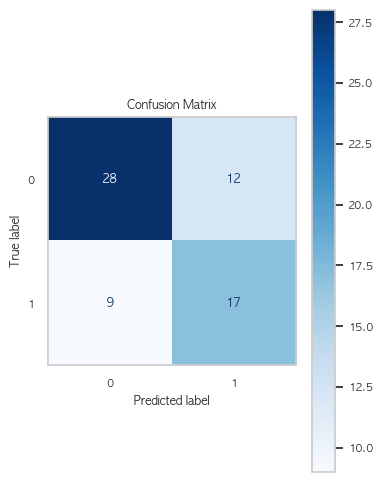

In [117]:
# Confusion Matrix 생성
cm = confusion_matrix(y_test, y_test_pred)

# Confusion Matrix 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

plt.grid(False)  # 그리드 제거
plt.title("Confusion Matrix")  # 제목 추가
plt.show()

- 속성 중요도 확인

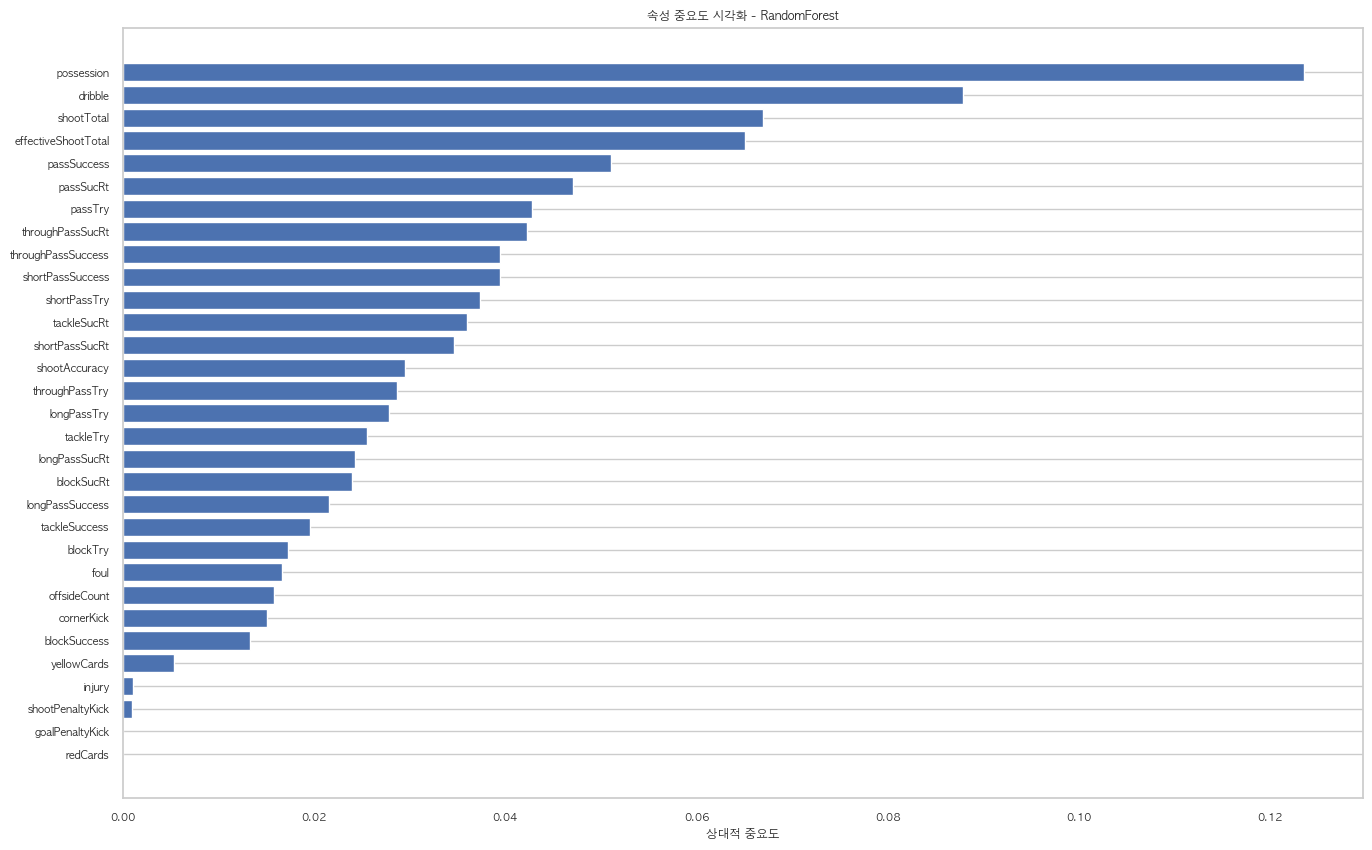

In [118]:
# 속성 중요도 추출
importances = best_model.feature_importances_

# 속성 이름 정의
feature_names = X_res.columns

# 속성 중요도 시각화
indices = np.argsort(importances)

plt.figure(figsize=(16, 10))
plt.title("속성 중요도 시각화 - RandomForest")
plt.barh(range(len(indices)), importances[indices], color="b", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("상대적 중요도")
plt.grid(axis='x')
plt.show()

#### 2) XGBoost

In [119]:
# XGBoost 모델 초기화
xgb_model = XGBClassifier(eval_metric='logloss', objective="binary:logistic", random_state=42)

# 그리드 서치를 위한 하이퍼파라미터 설정
param_grid = {
    'n_estimators': [50, 100, 200, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.2, 0.5],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# GridSearchCV 수행
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_res, y_res)

# 최적 모델 선택
best_model = grid_search.best_estimator_

# 최적 모델로 예측 수행
y_test_pred = best_model.predict(X_test)

Fitting 5 folds for each of 540 candidates, totalling 2700 fits


##### ㄴ 결과 확인

In [120]:
# 최적 파라미터 출력
print(f'최적 파라미터: {grid_search.best_params_}')

# 모델 예측
y_test_pred = grid_search.predict(X_test)
y_test_proba = grid_search.predict_proba(X_test)[:, 1]  # 양성 클래스(1)에 대한 확률 예측값

# 평가 지표 계산 (이진 분류 적용)
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_proba)

# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test, y_test_pred)

# 결과 출력
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")

최적 파라미터: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}
Accuracy: 0.6818
Precision: 0.5714
Recall: 0.7692
F1 Score: 0.6557
ROC AUC: 0.6952
Confusion Matrix:
[[25 15]
 [ 6 20]]


- 클래스에 대한 확률 값 출력

In [121]:
# 테스트 데이터에 대한 확률 예측 (multi:softprob)
y_pred_prob = grid_search.predict_proba(X_test)

# 예측된 확률 중 가장 큰 값의 인덱스를 예측 레이블로 변환
y_pred = np.argmax(y_pred_prob, axis=1)

# Macro F1-score 계산
macro_f1 = f1_score(y_test, y_pred, average='macro')

# Log Loss 계산
log_loss_value = log_loss(y_test, y_pred_prob)

# 평가 결과 출력
print(f'Macro F1-Score: {macro_f1:.4f}')
print(f'Log Loss: {log_loss_value:.4f}')

Macro F1-Score: 0.6800
Log Loss: 0.8239


In [122]:
# 분류 리포트 확인
report = classification_report(y_test, y_test_pred)
print('Classification Report:\n', report)

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.62      0.70        40
           1       0.57      0.77      0.66        26

    accuracy                           0.68        66
   macro avg       0.69      0.70      0.68        66
weighted avg       0.71      0.68      0.69        66



- 혼동 행렬 시각화

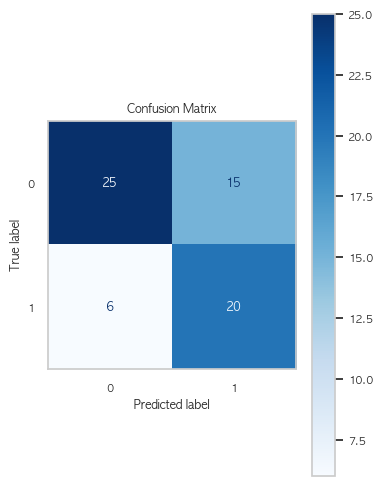

In [123]:
# Confusion Matrix 생성
cm = confusion_matrix(y_test, y_test_pred)

# Confusion Matrix 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

plt.grid(False)  # 그리드 제거
plt.title("Confusion Matrix")  # 제목 추가
plt.show()

- 속성 중요도 확인

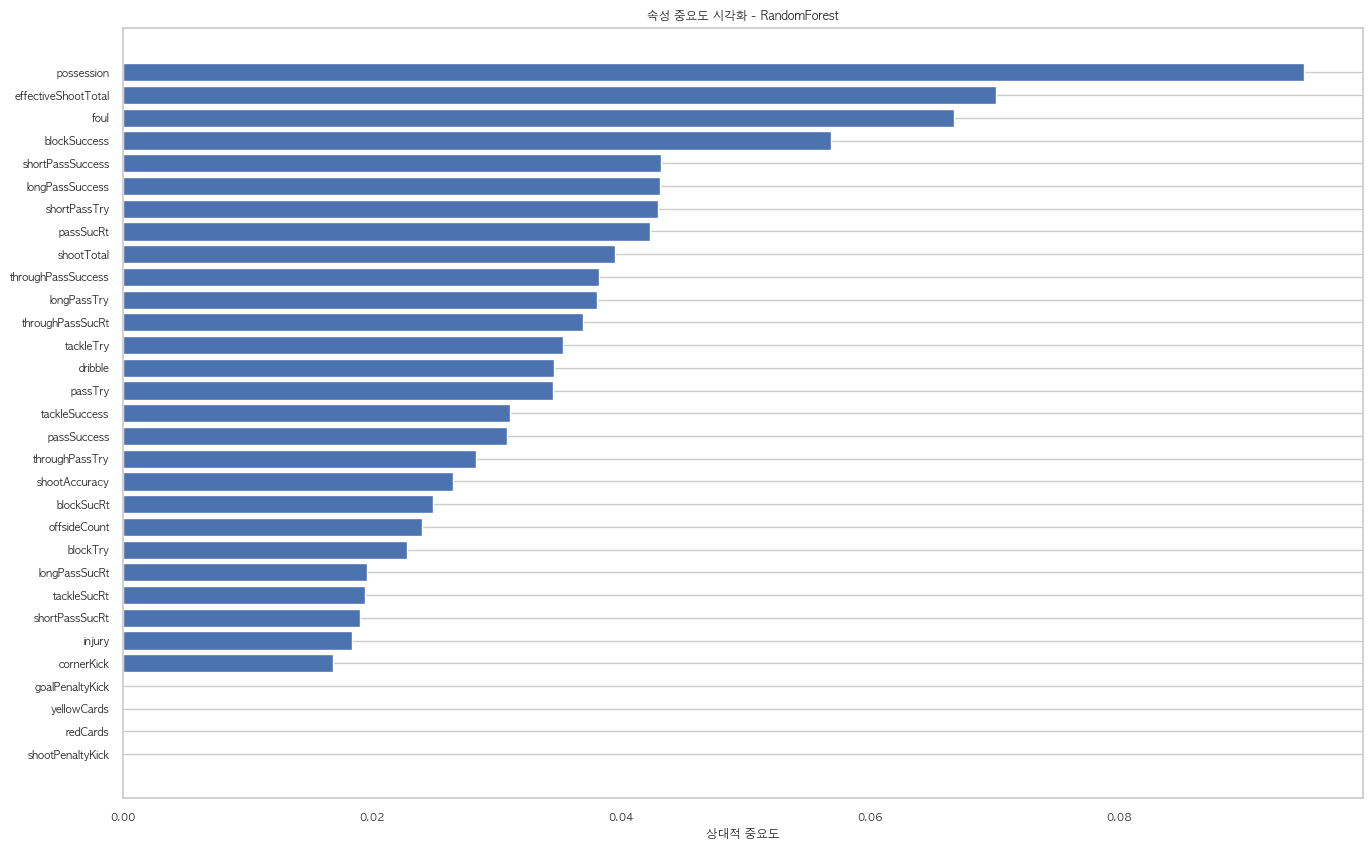

In [124]:
# 속성 중요도 추출
importances = best_model.feature_importances_

# 속성 이름 정의
feature_names = X_res.columns

# 속성 중요도 시각화
indices = np.argsort(importances)

plt.figure(figsize=(16, 10))
plt.title("속성 중요도 시각화 - RandomForest")
plt.barh(range(len(indices)), importances[indices], color="b", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("상대적 중요도")
plt.grid(axis='x')
plt.show()

#### --- 오버샘플링 X ---

#### 1) RadomForest

In [125]:
# 랜덤 포레스트 모델 초기화
rf_model = RandomForestClassifier(random_state=42)

# 그리드 서치를 위한 하이퍼파라미터 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# GridSearchCV 수행
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='f1_macro', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 최적 모델 선택
best_model = grid_search.best_estimator_

# 최적 모델로 예측 수행
y_test_pred = best_model.predict(X_test)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


##### ㄴ 결과 확인

In [126]:
# 최적 파라미터 출력
print(f'최적 파라미터: {grid_search.best_params_}')

# 모델 예측
y_test_pred = grid_search.predict(X_test)
y_test_proba = grid_search.predict_proba(X_test)[:, 1]  # 양성 클래스(1)에 대한 확률 예측값

# 평가 지표 계산 (이진 분류 적용)
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_proba)

# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test, y_test_pred)

# 결과 출력
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")

최적 파라미터: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Accuracy: 0.7121
Precision: 0.6207
Recall: 0.6923
F1 Score: 0.6545
ROC AUC: 0.7567
Confusion Matrix:
[[29 11]
 [ 8 18]]


In [127]:
# 분류 리포트 확인
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.72      0.75        40
           1       0.62      0.69      0.65        26

    accuracy                           0.71        66
   macro avg       0.70      0.71      0.70        66
weighted avg       0.72      0.71      0.71        66



- 혼동 행렬 시각화

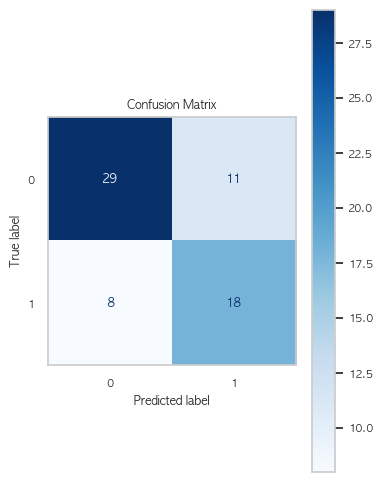

In [128]:
# Confusion Matrix 생성
cm = confusion_matrix(y_test, y_test_pred)

# Confusion Matrix 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

plt.grid(False)  # 그리드 제거
plt.title("Confusion Matrix")  # 제목 추가
plt.show()

- 속성 중요도 확인

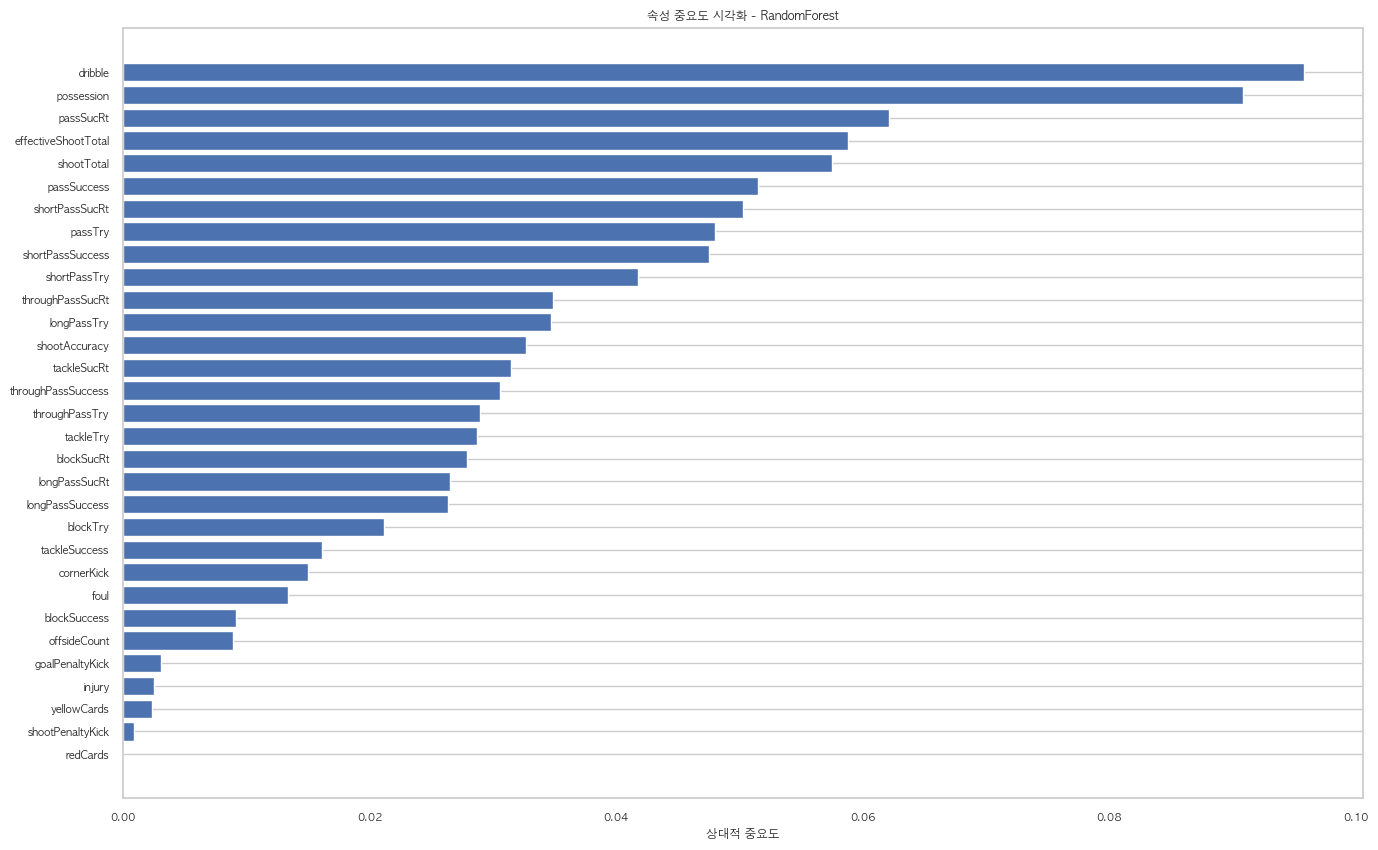

In [ ]:
# 속성 중요도 추출
importances = best_model.feature_importances_

# 속성 이름 정의
feature_names = X.columns

# 속성 중요도 시각화
indices = np.argsort(importances)

plt.figure(figsize=(16, 10))
plt.title("속성 중요도 시각화 - RandomForest")
plt.barh(range(len(indices)), importances[indices], color="b", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("상대적 중요도")
plt.grid(axis='x')
plt.show()

#### 2) XGBoost

In [130]:
# XGBoost 모델 초기화
xgb_model = XGBClassifier(eval_metric='logloss', objective="binary:logistic", random_state=42)

# 그리드 서치를 위한 하이퍼파라미터 설정
param_grid = {
    'n_estimators': [50, 100, 200, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.2, 0.5],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# GridSearchCV 수행
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 최적 모델 선택
best_model = grid_search.best_estimator_

# 최적 모델로 예측 수행
y_test_pred = best_model.predict(X_test)

Fitting 5 folds for each of 540 candidates, totalling 2700 fits


##### ㄴ 결과 확인

In [131]:
# 최적 파라미터 출력
print(f'최적 파라미터: {grid_search.best_params_}')

# 모델 예측
y_test_pred = grid_search.predict(X_test)
y_test_proba = grid_search.predict_proba(X_test)[:, 1]  # 양성 클래스(1)에 대한 확률 예측값

# 평가 지표 계산 (이진 분류 적용)
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_proba)

# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test, y_test_pred)

# 결과 출력
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")

최적 파라미터: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.8}
Accuracy: 0.6818
Precision: 0.6000
Recall: 0.5769
F1 Score: 0.5882
ROC AUC: 0.7327
Confusion Matrix:
[[30 10]
 [11 15]]


- 클래스에 대한 확률 값 출력

In [132]:
# 테스트 데이터에 대한 확률 예측 (multi:softprob)
y_pred_prob = grid_search.predict_proba(X_test)

# 예측된 확률 중 가장 큰 값의 인덱스를 예측 레이블로 변환
y_pred = np.argmax(y_pred_prob, axis=1)

# Macro F1-score 계산
macro_f1 = f1_score(y_test, y_pred, average='macro')

# Log Loss 계산
log_loss_value = log_loss(y_test, y_pred_prob)

# 평가 결과 출력
print(f'Macro F1-Score: {macro_f1:.4f}')
print(f'Log Loss: {log_loss_value:.4f}')

Macro F1-Score: 0.6645
Log Loss: 0.6119


In [133]:
# 분류 리포트 확인
report = classification_report(y_test, y_test_pred)
print('Classification Report:\n', report)

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.75      0.74        40
           1       0.60      0.58      0.59        26

    accuracy                           0.68        66
   macro avg       0.67      0.66      0.66        66
weighted avg       0.68      0.68      0.68        66



- 혼동 행렬 시각화

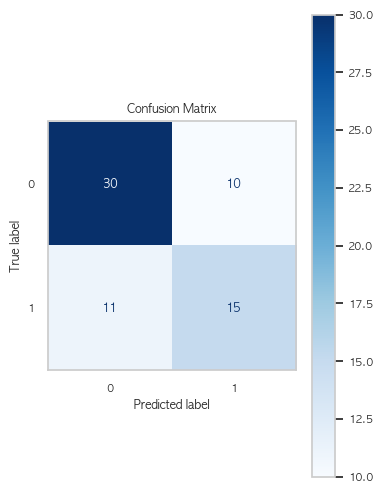

In [134]:
# Confusion Matrix 생성
cm = confusion_matrix(y_test, y_test_pred)

# Confusion Matrix 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

plt.grid(False)  # 그리드 제거
plt.title("Confusion Matrix")  # 제목 추가
plt.show()

- 속성 중요도 확인

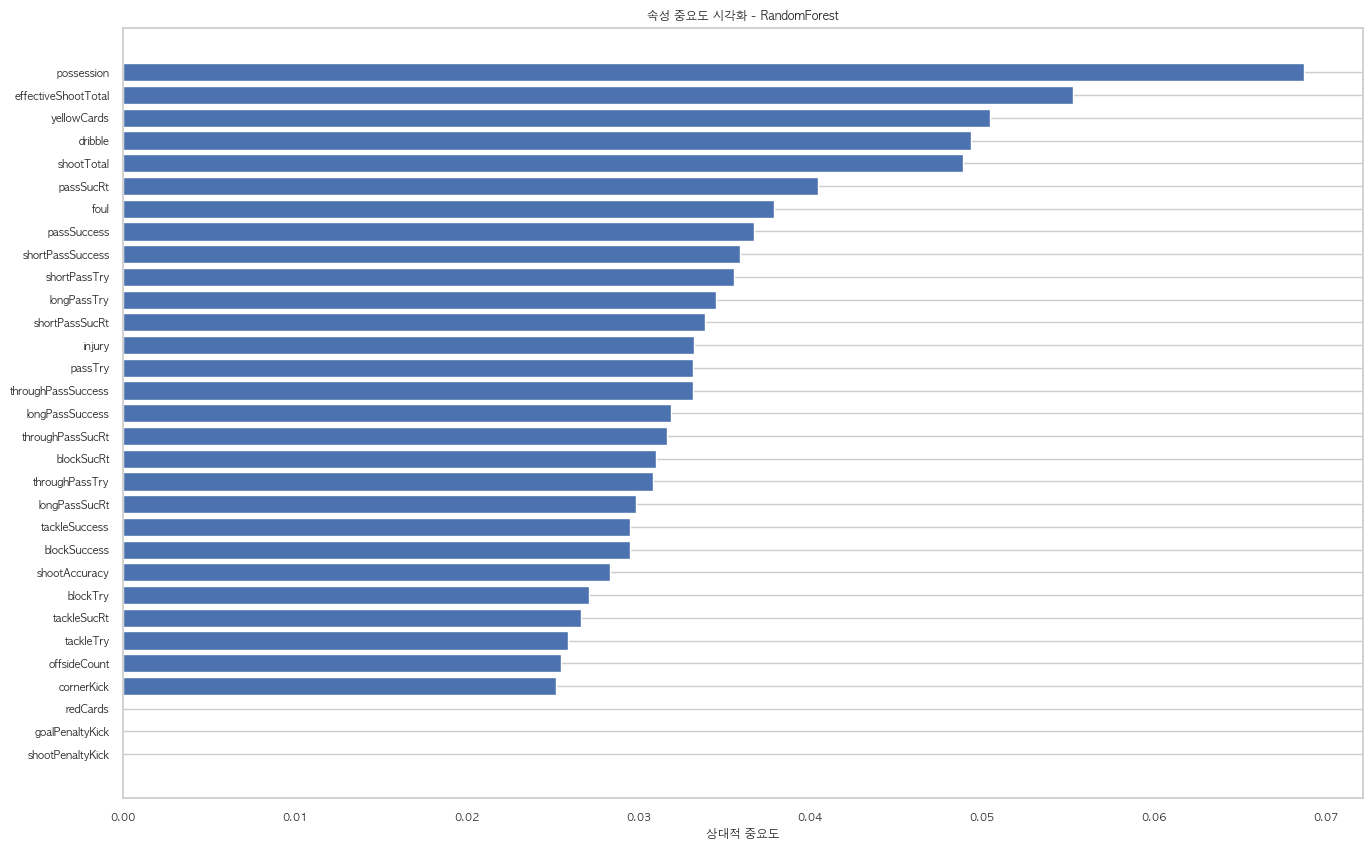

In [ ]:
# 속성 중요도 추출
importances = best_model.feature_importances_

# 속성 이름 정의
feature_names = X.columns

# 속성 중요도 시각화
indices = np.argsort(importances)

plt.figure(figsize=(16, 10))
plt.title("속성 중요도 시각화 - RandomForest")
plt.barh(range(len(indices)), importances[indices], color="b", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("상대적 중요도")
plt.grid(axis='x')
plt.show()

#### -- 파생변수 생성 X Ver --

#### --- 오버샘플링 O ---

#### 1) RadomForest

In [243]:
# 랜덤 포레스트 모델 초기화
rf_model = RandomForestClassifier(random_state=42)

# 그리드 서치를 위한 하이퍼파라미터 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# GridSearchCV 수행
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_no_res, y_no_res)

# 최적 모델 선택
best_model = grid_search.best_estimator_

# 최적 모델로 예측 수행
y_test_pred = best_model.predict(X_no_test)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


##### ㄴ 결과 확인

In [245]:
# 최적 파라미터 출력
print(f'최적 파라미터: {grid_search.best_params_}')

# 모델 예측
y_test_pred = grid_search.predict(X_no_test)
y_test_proba = grid_search.predict_proba(X_no_test)[:, 1]  # 양성 클래스(1)에 대한 확률 예측값

# 평가 지표 계산 (이진 분류 적용)
accuracy = accuracy_score(y_no_test, y_test_pred)
precision = precision_score(y_no_test, y_test_pred)
recall = recall_score(y_no_test, y_test_pred)
f1 = f1_score(y_no_test, y_test_pred)
roc_auc = roc_auc_score(y_no_test, y_test_proba)

# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_no_test, y_test_pred)

# 결과 출력
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")

최적 파라미터: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.6818
Precision: 0.5862
Recall: 0.6538
F1 Score: 0.6182
ROC AUC: 0.7404
Confusion Matrix:
[[28 12]
 [ 9 17]]


In [249]:
# 분류 리포트 확인
print("\nClassification Report:")
print(classification_report(y_no_test, y_test_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.70      0.73        40
           1       0.59      0.65      0.62        26

    accuracy                           0.68        66
   macro avg       0.67      0.68      0.67        66
weighted avg       0.69      0.68      0.68        66



- 혼동 행렬 시각화

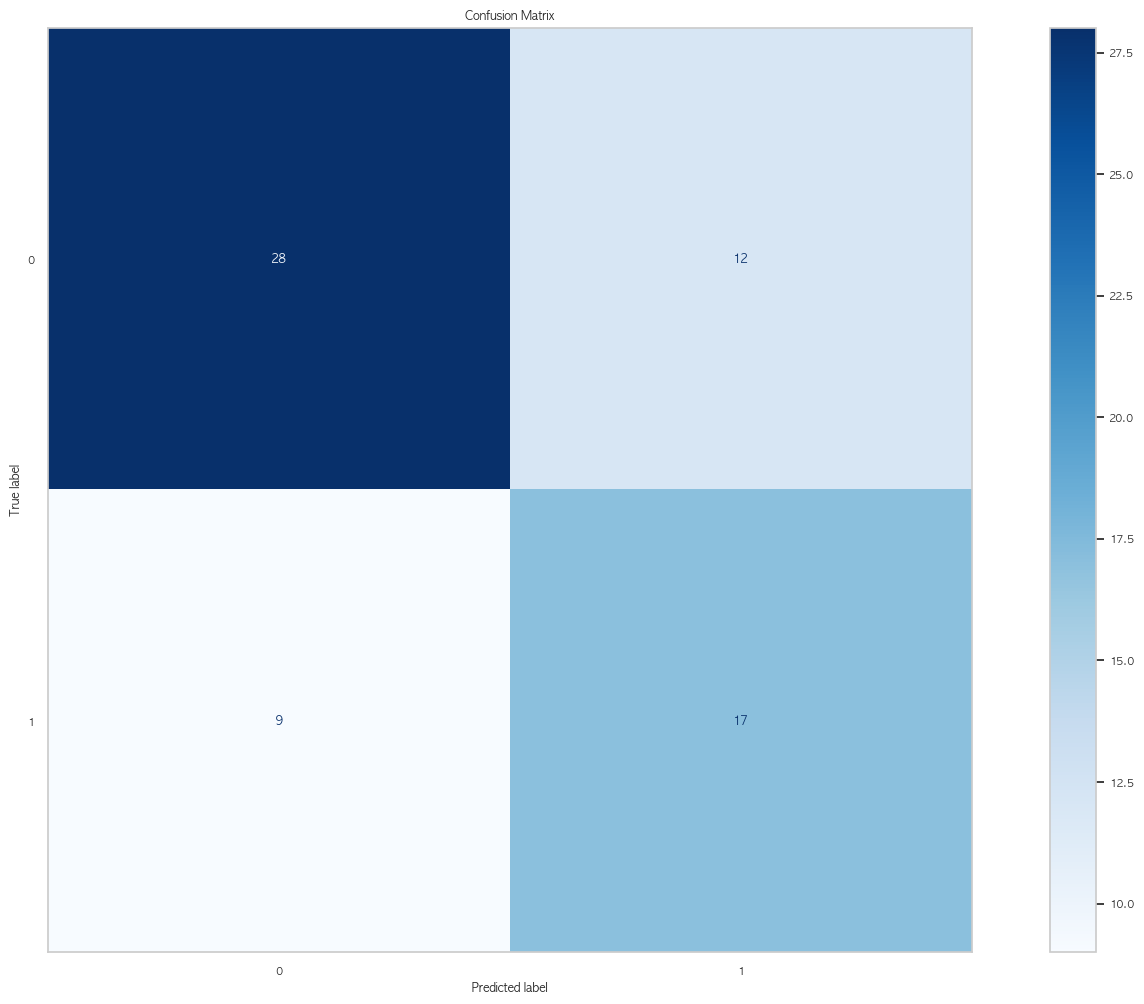

In [250]:
# Confusion Matrix 생성
cm = confusion_matrix(y_no_test, y_test_pred)

# Confusion Matrix 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

plt.grid(False)  # 그리드 제거
plt.title("Confusion Matrix")  # 제목 추가
plt.show()

- 속성 중요도 확인

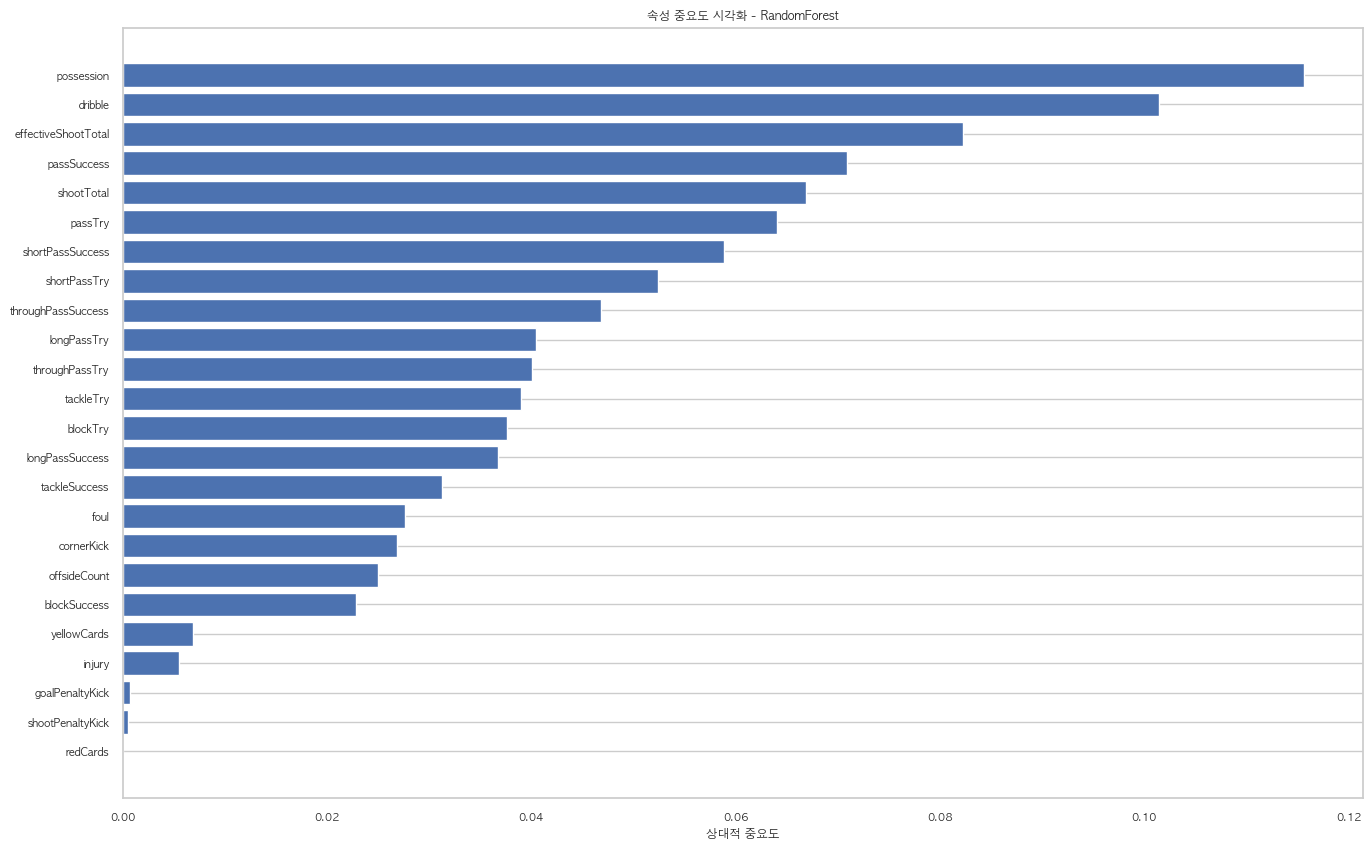

In [251]:
# 속성 중요도 추출
importances = best_model.feature_importances_

# 속성 이름 정의
feature_names = X_no_res.columns

# 속성 중요도 시각화
indices = np.argsort(importances)

plt.figure(figsize=(16, 10))
plt.title("속성 중요도 시각화 - RandomForest")
plt.barh(range(len(indices)), importances[indices], color="b", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("상대적 중요도")
plt.grid(axis='x')
plt.show()

#### 2) XGBoost

In [ ]:
# XGBoost 모델 초기화
xgb_model = XGBClassifier(eval_metric='logloss', objective="binary:logistic", random_state=42)

# 그리드 서치를 위한 하이퍼파라미터 설정
param_grid = {
    'n_estimators': [50, 100, 200, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.2, 0.5],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# GridSearchCV 수행
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_res, y_res)

# 최적 모델 선택
best_model = grid_search.best_estimator_

# 최적 모델로 예측 수행
y_test_pred = best_model.predict(X_test)

Fitting 5 folds for each of 540 candidates, totalling 2700 fits


##### ㄴ 결과 확인

In [ ]:
# 최적 파라미터 출력
print(f'최적 파라미터: {grid_search.best_params_}')

# 모델 예측
y_test_pred = grid_search.predict(X_no_test)
y_test_proba = grid_search.predict_proba(X_no_test)[:, 1]  # 양성 클래스(1)에 대한 확률 예측값

# 평가 지표 계산 (이진 분류 적용)
accuracy = accuracy_score(y_no_test, y_test_pred)
precision = precision_score(y_no_test, y_test_pred)
recall = recall_score(y_no_test, y_test_pred)
f1 = f1_score(y_no_test, y_test_pred)
roc_auc = roc_auc_score(y_no_test, y_test_proba)

# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_no_test, y_test_pred)

# 결과 출력
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")

최적 파라미터: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}
Accuracy: 0.6818
Precision: 0.5714
Recall: 0.7692
F1 Score: 0.6557
ROC AUC: 0.6952
Confusion Matrix:
[[25 15]
 [ 6 20]]


- 클래스에 대한 확률 값 출력

In [ ]:
# 테스트 데이터에 대한 확률 예측 (multi:softprob)
y_pred_prob = grid_search.predict_proba(X_no_test)

# 예측된 확률 중 가장 큰 값의 인덱스를 예측 레이블로 변환
y_pred = np.argmax(y_pred_prob, axis=1)

# Macro F1-score 계산
macro_f1 = f1_score(y_no_test, y_pred, average='macro')

# Log Loss 계산
log_loss_value = log_loss(y_no_test, y_pred_prob)

# 평가 결과 출력
print(f'Macro F1-Score: {macro_f1:.4f}')
print(f'Log Loss: {log_loss_value:.4f}')

Macro F1-Score: 0.6800
Log Loss: 0.8239


In [ ]:
# 분류 리포트 확인
report = classification_report(y_no_test, y_test_pred)
print('Classification Report:\n', report)

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.62      0.70        40
           1       0.57      0.77      0.66        26

    accuracy                           0.68        66
   macro avg       0.69      0.70      0.68        66
weighted avg       0.71      0.68      0.69        66



- 혼동 행렬 시각화

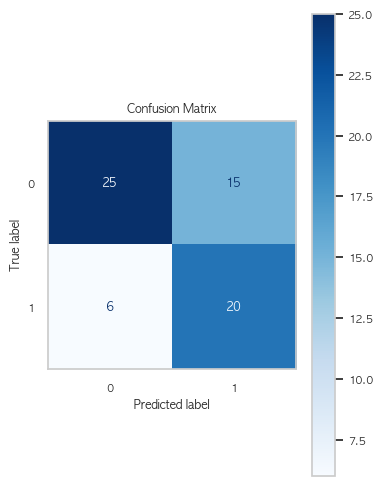

In [ ]:
# Confusion Matrix 생성
cm = confusion_matrix(y_no_test, y_test_pred)

# Confusion Matrix 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

plt.grid(False)  # 그리드 제거
plt.title("Confusion Matrix")  # 제목 추가
plt.show()

- 속성 중요도 확인

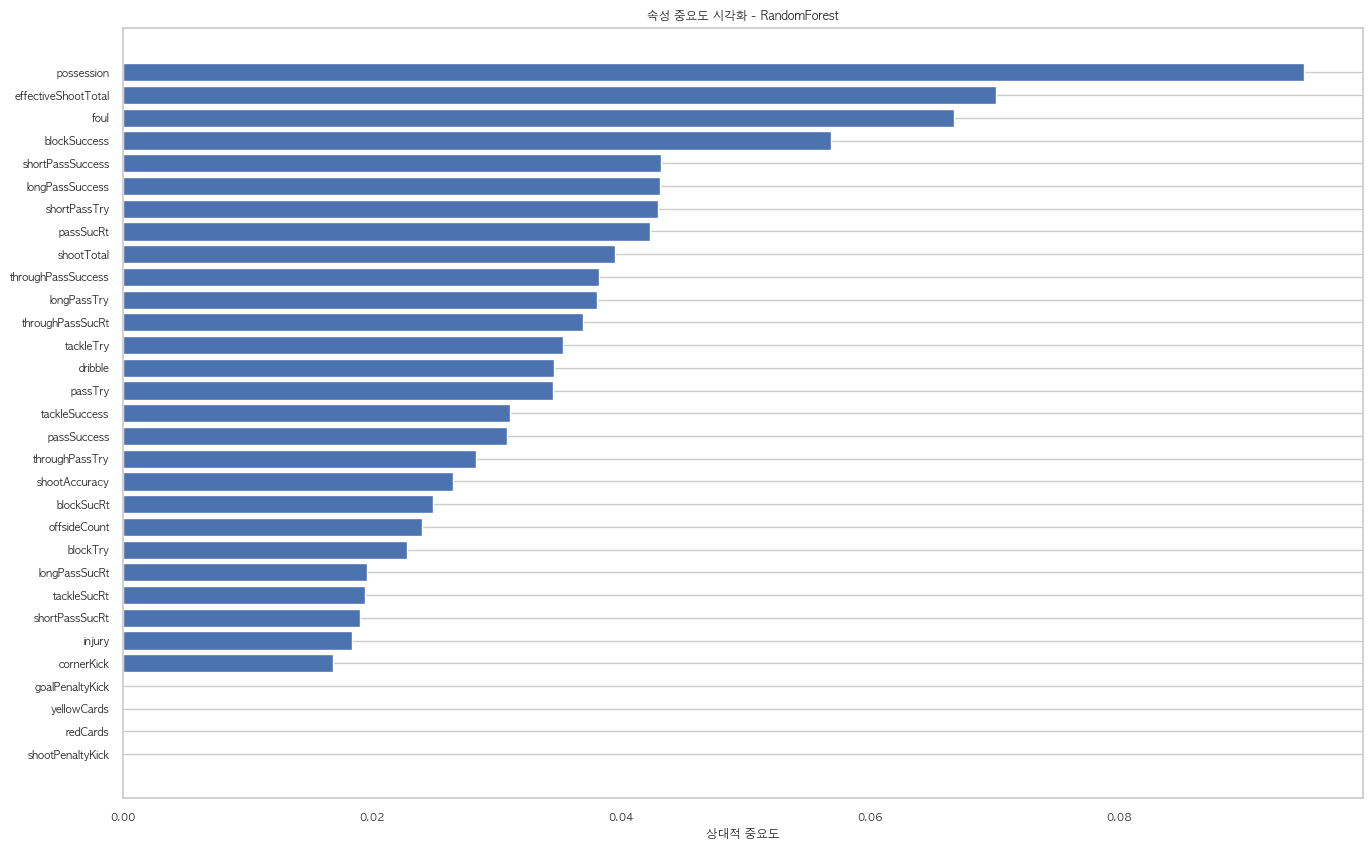

In [ ]:
# 속성 중요도 추출
importances = best_model.feature_importances_

# 속성 이름 정의
feature_names = X_no_res.columns

# 속성 중요도 시각화
indices = np.argsort(importances)

plt.figure(figsize=(16, 10))
plt.title("속성 중요도 시각화 - RandomForest")
plt.barh(range(len(indices)), importances[indices], color="b", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("상대적 중요도")
plt.grid(axis='x')
plt.show()

#### --- 오버샘플링 X ---

#### 1) RadomForest

In [ ]:
# 랜덤 포레스트 모델 초기화
rf_model = RandomForestClassifier(random_state=42)

# 그리드 서치를 위한 하이퍼파라미터 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# GridSearchCV 수행
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='f1_macro', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 최적 모델 선택
best_model = grid_search.best_estimator_

# 최적 모델로 예측 수행
y_test_pred = best_model.predict(X_test)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


##### ㄴ 결과 확인

In [ ]:
# 최적 파라미터 출력
print(f'최적 파라미터: {grid_search.best_params_}')

# 모델 예측
y_test_pred = grid_search.predict(X_no_test)
y_test_proba = grid_search.predict_proba(X_no_test)[:, 1]  # 양성 클래스(1)에 대한 확률 예측값

# 평가 지표 계산 (이진 분류 적용)
accuracy = accuracy_score(y_no_test, y_test_pred)
precision = precision_score(y_no_test, y_test_pred)
recall = recall_score(y_no_test, y_test_pred)
f1 = f1_score(y_no_test, y_test_pred)
roc_auc = roc_auc_score(y_no_test, y_test_proba)

# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_no_test, y_test_pred)

# 결과 출력
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")

최적 파라미터: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.6818
Precision: 0.5862
Recall: 0.6538
F1 Score: 0.6182
ROC AUC: 0.7404
Confusion Matrix:
[[28 12]
 [ 9 17]]


In [ ]:
# 분류 리포트 확인
print("\nClassification Report:")
print(classification_report(y_no_test, y_test_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.70      0.73        40
           1       0.59      0.65      0.62        26

    accuracy                           0.68        66
   macro avg       0.67      0.68      0.67        66
weighted avg       0.69      0.68      0.68        66



- 혼동 행렬 시각화

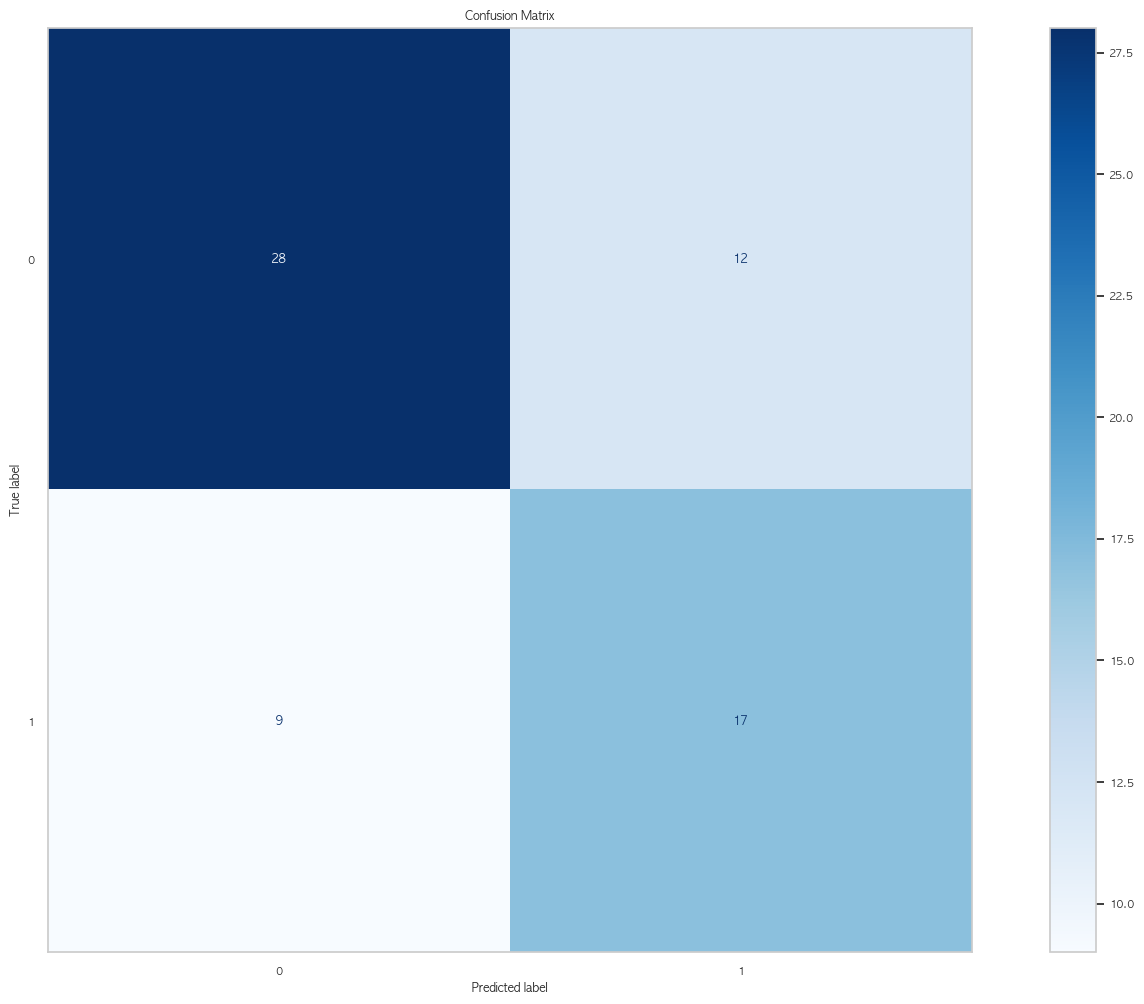

In [ ]:
# Confusion Matrix 생성
cm = confusion_matrix(y_no_test, y_test_pred)

# Confusion Matrix 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

plt.grid(False)  # 그리드 제거
plt.title("Confusion Matrix")  # 제목 추가
plt.show()

- 속성 중요도 확인

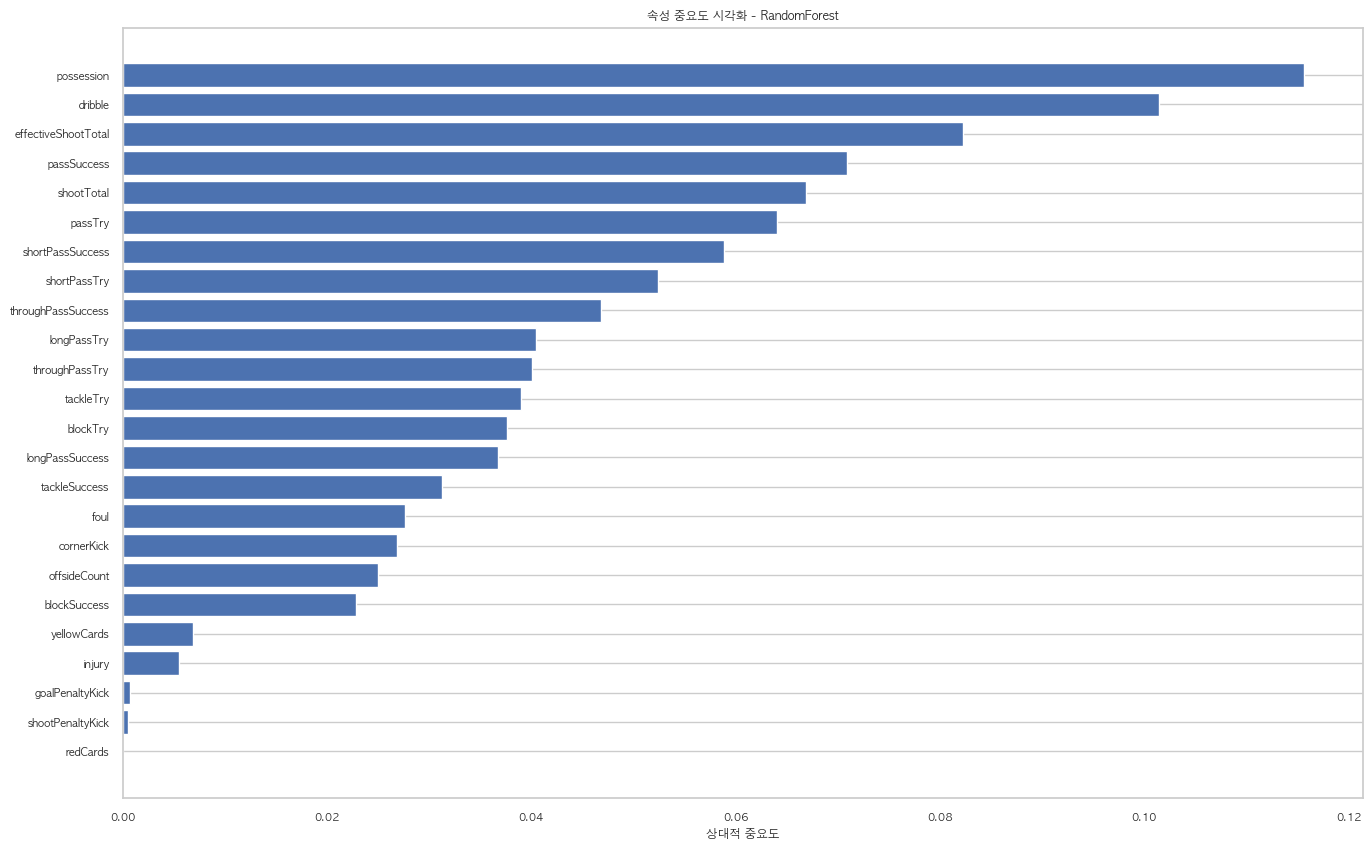

In [ ]:
# 속성 중요도 추출
importances = best_model.feature_importances_

# 속성 이름 정의
feature_names = X_no.columns

# 속성 중요도 시각화
indices = np.argsort(importances)

plt.figure(figsize=(16, 10))
plt.title("속성 중요도 시각화 - RandomForest")
plt.barh(range(len(indices)), importances[indices], color="b", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("상대적 중요도")
plt.grid(axis='x')
plt.show()

#### 2) XGBoost

In [ ]:
# XGBoost 모델 초기화
xgb_model = XGBClassifier(eval_metric='logloss', objective="binary:logistic", random_state=42)

# 그리드 서치를 위한 하이퍼파라미터 설정
param_grid = {
    'n_estimators': [50, 100, 200, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.2, 0.5],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# GridSearchCV 수행
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 최적 모델 선택
best_model = grid_search.best_estimator_

# 최적 모델로 예측 수행
y_test_pred = best_model.predict(X_test)

Fitting 5 folds for each of 540 candidates, totalling 2700 fits


##### ㄴ 결과 확인

In [ ]:
# 최적 파라미터 출력
print(f'최적 파라미터: {grid_search.best_params_}')

# 모델 예측
y_test_pred = grid_search.predict(X_no_test)
y_test_proba = grid_search.predict_proba(X_no_test)[:, 1]  # 양성 클래스(1)에 대한 확률 예측값

# 평가 지표 계산 (이진 분류 적용)
accuracy = accuracy_score(y_no_test, y_test_pred)
precision = precision_score(y_no_test, y_test_pred)
recall = recall_score(y_no_test, y_test_pred)
f1 = f1_score(y_no_test, y_test_pred)
roc_auc = roc_auc_score(y_no_test, y_test_proba)

# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_no_test, y_test_pred)

# 결과 출력
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")

최적 파라미터: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}
Accuracy: 0.6818
Precision: 0.5714
Recall: 0.7692
F1 Score: 0.6557
ROC AUC: 0.6952
Confusion Matrix:
[[25 15]
 [ 6 20]]


- 클래스에 대한 확률 값 출력

In [ ]:
# 테스트 데이터에 대한 확률 예측 (multi:softprob)
y_pred_prob = grid_search.predict_proba(X_no_test)

# 예측된 확률 중 가장 큰 값의 인덱스를 예측 레이블로 변환
y_pred = np.argmax(y_pred_prob, axis=1)

# Macro F1-score 계산
macro_f1 = f1_score(y_no_test, y_pred, average='macro')

# Log Loss 계산
log_loss_value = log_loss(y_no_test, y_pred_prob)

# 평가 결과 출력
print(f'Macro F1-Score: {macro_f1:.4f}')
print(f'Log Loss: {log_loss_value:.4f}')

Macro F1-Score: 0.6800
Log Loss: 0.8239


In [ ]:
# 분류 리포트 확인
report = classification_report(y_no_test, y_test_pred)
print('Classification Report:\n', report)

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.62      0.70        40
           1       0.57      0.77      0.66        26

    accuracy                           0.68        66
   macro avg       0.69      0.70      0.68        66
weighted avg       0.71      0.68      0.69        66



- 혼동 행렬 시각화

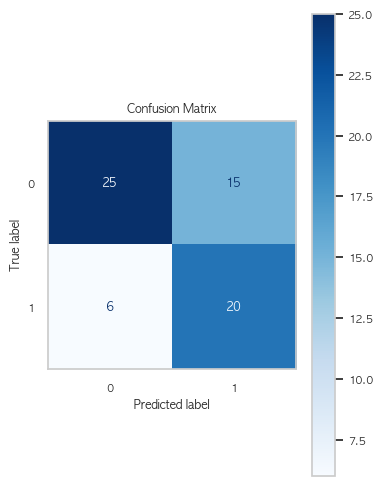

In [ ]:
# Confusion Matrix 생성
cm = confusion_matrix(y_no_test, y_test_pred)

# Confusion Matrix 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

plt.grid(False)  # 그리드 제거
plt.title("Confusion Matrix")  # 제목 추가
plt.show()

- 속성 중요도 확인

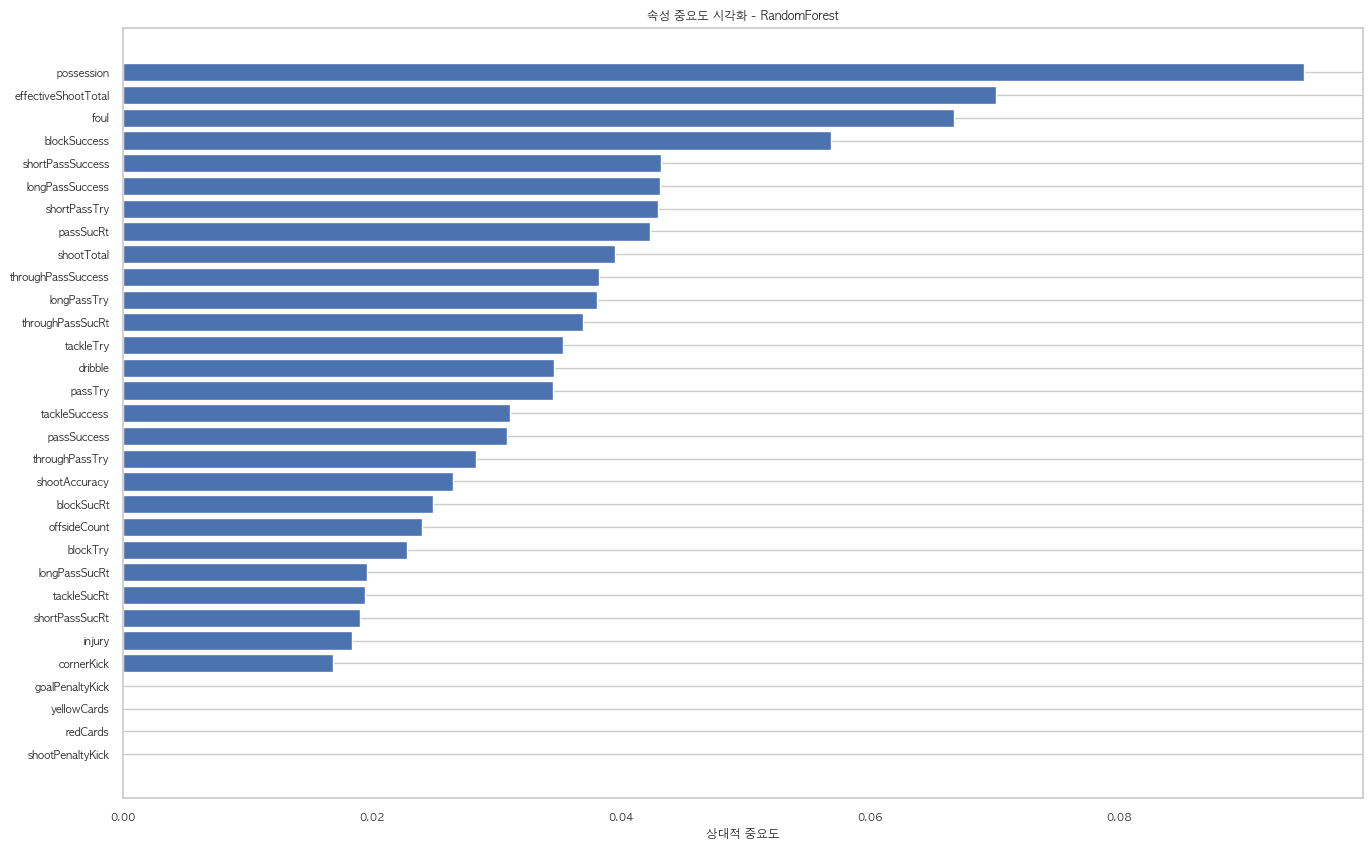

In [ ]:
# 속성 중요도 추출
importances = best_model.feature_importances_

# 속성 이름 정의
feature_names = X_no.columns

# 속성 중요도 시각화
indices = np.argsort(importances)

plt.figure(figsize=(16, 10))
plt.title("속성 중요도 시각화 - RandomForest")
plt.barh(range(len(indices)), importances[indices], color="b", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("상대적 중요도")
plt.grid(axis='x')
plt.show()